CELDA C1 — Imports, reproducibilidad y métricas
Configuro entorno básico y defino métricas comunes.

In [2]:

import numpy as np
import pandas as pd
import random

RANDOM_STATE = 1337
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

from sklearn.metrics import mean_absolute_error, r2_score
try:
    from sklearn.metrics import root_mean_squared_error
    def _rmse(y_true, y_pred): return root_mean_squared_error(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def _rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

def _metrics(y_true, y_pred):
    rmse = _rmse(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    hit  = (np.sign(y_true) == np.sign(y_pred)).mean()
    return rmse, mae, r2, hit


CELDA C2 — Walk-forward con gap y evaluador genérico

Genero splits temporales y una rutina de evaluación por folds con baseline.

In [3]:
# CELDA C2 — Walk-forward con gap y evaluador genérico (determinista)

import numpy as np
import pandas as pd

def make_walk_forward_splits(n_samples, train_min, val_size, n_splits, gap=0):
    """
    Ventana de entrenamiento creciente + ventana de validación fija.
    Devuelve lista de (train_idx, val_idx) sin aleatoriedad.
    """
    splits = []
    for i in range(n_splits):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        if val_end > n_samples:
            break
        train_idx = np.arange(0, train_end)
        val_idx   = np.arange(val_start, val_end)
        splits.append((train_idx, val_idx))
    return splits

def eval_model_wf(estimator, X, y, splits, random_state=1337):
    """
    Ajusta y evalúa un estimador en cada fold temporal.
    Para reproducibilidad total resiembra al arrancar.
    """
    np.random.seed(random_state)
    random.seed(random_state)

    rows = []
    for k, (tr, va) in enumerate(splits, start=1):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]

        # Baseline: constante con la media de ytr
        y_base = np.full_like(yva, ytr.mean(), dtype=float)
        b_rmse, b_mae, b_r2, b_hit = _metrics(yva, y_base)

        # Modelo
        estimator.fit(Xtr, ytr)
        yhat = estimator.predict(Xva)
        rmse, mae, r2, hit = _metrics(yva, yhat)

        skill_rmse = 1.0 - (rmse / b_rmse) if b_rmse > 0 else np.nan

        rows.append({
            "fold": k,
            "rmse": rmse, "mae": mae, "r2": r2, "hit": hit,
            "base_rmse": b_rmse, "base_mae": b_mae, "base_r2": b_r2, "base_hit": b_hit,
            "skill_rmse": skill_rmse
        })

    df = pd.DataFrame(rows)
    summary = df[["rmse","mae","r2","hit","skill_rmse"]].mean().to_frame("mean")
    summary["std"] = df[["rmse","mae","r2","hit","skill_rmse"]].std()
    return df, summary


CELDA C3 — carga de datos y configuración de los 4 csv

Defino carga de X/y y apunto los cuatro datasets (misma carpeta que el notebook).

In [4]:
# CELDA C3 — Carga de datos y configuración de los 4 CSV

import pandas as pd

def load_xy(csv_path, target_col="target_21d_logret_fwd", date_col="Date"):
    df = pd.read_csv(csv_path)
    if date_col in df.columns:
        df = df.sort_values(date_col).reset_index(drop=True)

    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if target_col not in df.columns:
        raise ValueError(f"No encuentro la columna objetivo: {target_col}")

    feature_cols = [c for c in num_cols if c != target_col]
    X = df[feature_cols].values
    y = df[target_col].values
    return df, X, y, feature_cols

FILES = {
    "muy_corto": ("AMZN_modelo_muy_corto_train.csv",  "target_1d_logret_fwd"),
    "corto"    : ("AMZN_modelo_corto_train.csv",      "target_21d_logret_fwd"),
    "medio"    : ("AMZN_modelo_medio_train.csv",      "target_252d_logret_fwd"),
    "largo"    : ("AMZN_modelo_largo_train.csv",      "target_504d_logret_fwd"),
}

SPLITS = 5
GAP    = 0
RANDOM_STATE = 1337  # para usar como random_state en cada estimador


LINEALES
CELDA L1 — Modelos lineales (OLS, LassoCV, ElasticNetCV)

Defino pipelines lineales con escalado y CV temporal interno donde aplica.

In [5]:
# LINEALES CELDA L1 — Modelos lineales (OLS, LassoCV, ElasticNetCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit

inner_cv = TimeSeriesSplit(n_splits=3)

ols = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LassoCV(
        alphas=np.logspace(-4, 0, 25),
        cv=inner_cv,
        max_iter=20000,
        n_jobs=1,
        random_state=RANDOM_STATE
    ))
])

enet = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        alphas=np.logspace(-4, 0, 25),
        cv=inner_cv,
        max_iter=20000,
        n_jobs=1,
        random_state=RANDOM_STATE
    ))
])

LINEALES = {"OLS": ols, "LassoCV": lasso, "ElasticNetCV": enet}


CELDA L2 — Evaluación de lineales en los 4 horizontes

Itero por los cuatro CSV y muestro resumen por modelo/horizonte.

In [6]:
# CELDA L2 — Evaluación de lineales en los 4 horizontes (tabla "larga")
res_lineales = []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, _ = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    splits = make_walk_forward_splits(N, train_min, val_size, SPLITS, GAP)

    for nombre, est in LINEALES.items():
        _, summary = eval_model_wf(est, X, y, splits)
        out = summary.reset_index().rename(columns={"index": "metric"})
        out.insert(0, "modelo", nombre)
        out.insert(0, "horizonte", horizonte)
        res_lineales.append(out)

res_lineales_df = pd.concat(res_lineales, ignore_index=True).sort_values(["horizonte","modelo","metric"])
display(res_lineales_df[["horizonte","modelo","metric","mean","std"]])


,horizonte,modelo,metric,mean,std
28,corto,ElasticNetCV,hit,0.642000,0.047117
26,corto,ElasticNetCV,mae,0.065911,0.005616
27,corto,ElasticNetCV,r2,0.153320,0.144512
25,corto,ElasticNetCV,rmse,0.084446,0.008122
29,corto,ElasticNetCV,skill_rmse,0.085305,0.076602
23,corto,LassoCV,hit,0.642000,0.043818
21,corto,LassoCV,mae,0.065825,0.005736
22,corto,LassoCV,r2,0.155956,0.141411
20,corto,LassoCV,rmse,0.084352,0.008378
24,corto,LassoCV,skill_rmse,0.086624,0.075075


CELDA L3 — comparativa lineales (salida única)

tabla ancha con rmse/skill por horizonte y modelo.

In [7]:
# CELDA L3 — Comparativa lineales (tabla "ancha")
lin_wide = res_lineales_df.pivot_table(
    index=["horizonte", "modelo"],
    columns="metric",
    values="mean",
    aggfunc="first"
)
cols = [c for c in ["rmse", "mae", "r2", "hit", "skill_rmse"] if c in lin_wide.columns]
lin_wide = lin_wide[cols].reset_index()
display(lin_wide)


metric,horizonte,modelo,rmse,mae,r2,hit,skill_rmse
0,corto,ElasticNetCV,0.084446,0.065911,0.153320,0.642000,0.085305
1,corto,LassoCV,0.084352,0.065825,0.155956,0.642000,0.086624
2,corto,OLS,0.083139,0.064597,0.172560,0.648000,0.097013
3,largo,ElasticNetCV,0.063966,0.051576,0.981400,0.980645,0.863924
4,largo,LassoCV,0.063823,0.051470,0.981485,0.983871,0.864235
5,largo,OLS,0.063541,0.051234,0.981623,0.980645,0.864781
6,medio,ElasticNetCV,0.059597,0.044746,0.969812,0.944578,0.826680
7,medio,LassoCV,0.059662,0.044735,0.969744,0.944578,0.826486
8,medio,OLS,0.059532,0.044698,0.969867,0.944578,0.826872
9,muy_corto,ElasticNetCV,0.020796,0.015379,-0.012989,0.480000,0.000000


CELDA L4 - Sanity checks y afinado final de lineales

In [8]:
# CELDA LCLOSE — Sanity checks finales (purgado/embargo, baselines, sparsity, stats de target)

from sklearn.base import clone

# GAP (embargo) por horizonte
GAP_MAP = {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504}

def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

def eval_baselines(y, splits):
    if len(splits) == 0:
        return {"rmse_zero": np.nan, "mae_zero": np.nan, "r2_zero": np.nan,
                "hit_zero": np.nan, "hit_majority": np.nan,
                "train_pos_rate": np.nan, "val_pos_rate": np.nan}
    rows = []
    for (tr, va) in splits:
        ytr, yva = y[tr], y[va]
        y0 = np.zeros_like(yva)
        rmse0, mae0, r20, hit0 = _metrics(yva, y0)
        majority_sign = 1.0 if (ytr > 0).mean() >= 0.5 else -1.0
        hit_majority = (np.sign(yva) == majority_sign).mean()
        rows.append({
            "rmse_zero": rmse0, "mae_zero": mae0, "r2_zero": r20, "hit_zero": hit0,
            "hit_majority": hit_majority,
            "train_pos_rate": (ytr > 0).mean(), "val_pos_rate": (yva > 0).mean()
        })
    return pd.DataFrame(rows).mean(numeric_only=True).to_dict()

def last_fold_sparsity(estimator, X, y, splits):
    if len(splits) == 0:
        return {"coef_nnz": np.nan, "alpha_": np.nan, "l1_ratio_": np.nan}
    tr, va = splits[-1]
    est = clone(estimator).fit(X[tr], y[tr])
    info = {"coef_nnz": np.nan, "alpha_": np.nan, "l1_ratio_": np.nan}
    try:
        reg = getattr(est, "named_steps", {}).get("reg", est)
        coef = getattr(reg, "coef_", None)
        if coef is not None:
            info["coef_nnz"] = int(np.count_nonzero(np.abs(coef) > 1e-12))
        if hasattr(reg, "alpha_"):    info["alpha_"] = float(reg.alpha_)
        if hasattr(reg, "l1_ratio_"): info["l1_ratio_"] = float(reg.l1_ratio_)
    except Exception:
        pass
    return info

def safe_summary(estimator, X, y, splits, label_cv):
    if len(splits) == 0:
        return {"cv": f"{label_cv}(sin_folds)", "rmse": np.nan, "mae": np.nan,
                "r2": np.nan, "hit": np.nan, "skill_rmse": np.nan}
    _, s = eval_model_wf(clone(estimator), X, y, splits, random_state=RANDOM_STATE)
    return {"cv": label_cv, **{k: float(s.loc[k, "mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}}

comparativas, baselines_tbl, sparsity_tbl, target_stats, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)

    splits_default = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=GAP)
    splits_purged  = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=GAP_MAP[horizonte])

    if len(splits_purged) == 0:
        max_val = N - train_min - GAP_MAP[horizonte]
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits_purged = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=GAP_MAP[horizonte])
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado sin folds con val_size={val_size}; "
                                  f"ajustado a val_size={val_size_alt} y n_splits=1."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={GAP_MAP[horizonte]})."})

    b = eval_baselines(y, splits_purged); b.update({"horizonte": horizonte}); baselines_tbl.append(b)

    target_stats.append({"horizonte": horizonte, "n": N,
                         "mean_y": float(np.mean(y)), "std_y": float(np.std(y)),
                         "pos_rate_global": float((y > 0).mean())})

    for nombre, est in LINEALES.items():
        comparativas.append({"horizonte": horizonte, "modelo": nombre,
                             **safe_summary(est, X, y, splits_default, "actual")})
        comparativas.append({"horizonte": horizonte, "modelo": nombre,
                             **safe_summary(est, X, y, splits_purged, "purgado")})
        sp = last_fold_sparsity(est, X, y, splits_purged)
        sp.update({"horizonte": horizonte, "modelo": nombre, "n_features": len(feats)})
        sparsity_tbl.append(sp)

cmp_df = pd.DataFrame(comparativas).sort_values(["horizonte","modelo","cv"])
cmp_pivot = cmp_df.pivot_table(
    index=["horizonte","modelo"], columns="cv",
    values=["rmse","mae","r2","hit","skill_rmse"], aggfunc="first"
)
cmp_pivot = cmp_pivot.reindex(columns=[
    ("rmse","actual"),("rmse","purgado"),
    ("mae","actual"),("mae","purgado"),
    ("r2","actual"),("r2","purgado"),
    ("hit","actual"),("hit","purgado"),
    ("skill_rmse","actual"),("skill_rmse","purgado")
], fill_value=np.nan)

base_df = pd.DataFrame(baselines_tbl).sort_values("horizonte")[[
    "horizonte","rmse_zero","mae_zero","r2_zero","hit_zero","hit_majority","train_pos_rate","val_pos_rate"
]]
sps_df  = pd.DataFrame(sparsity_tbl).sort_values(["horizonte","modelo"])[
    ["horizonte","modelo","n_features","coef_nnz","alpha_","l1_ratio_"]
]
tgt_df  = pd.DataFrame(target_stats).sort_values("horizonte")[
    ["horizonte","n","mean_y","std_y","pos_rate_global"]
]
notes_df = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

display(cmp_pivot.reset_index())
display(base_df)
display(sps_df)
display(tgt_df)
if len(notes_df): display(notes_df)


horizonte        modelo      rmse                 mae                  r2  \
cv                             actual   purgado    actual   purgado    actual   
0       corto  ElasticNetCV  0.084446  0.084831  0.065911  0.066075  0.153320   
1       corto       LassoCV  0.084352  0.084637  0.065825  0.065944  0.155956   
2       corto           OLS  0.083139  0.083699  0.064597  0.064631  0.172560   
3       largo  ElasticNetCV  0.063966  0.078567  0.051576  0.066604  0.981400   
4       largo       LassoCV  0.063823  0.078559  0.051470  0.066631  0.981485   
5       largo           OLS  0.063541  0.069073  0.051234  0.055456  0.981623   
6       medio  ElasticNetCV  0.059597  0.060425  0.044746  0.045267  0.969812   
7       medio       LassoCV  0.059662  0.060444  0.044735  0.045210  0.969744   
8       medio           OLS  0.059532  0.060309  0.044698  0.045266  0.969867   
9   muy_corto  ElasticNetCV  0.020796  0.020839  0.015379  0.015418 -0.012989   
10  muy_corto       LassoCV  0.020796  0.020839  0.015379  0.015418 -0.012989   
11  muy_corto           OLS  0.022118  0.022165  0.016571  0.016603 -0.151897   

                   hit           skill_rmse            
cv   purgado    actual   purgado     actual   purgado  
0   0.137932  0.642000  0.640000   0.085305  0.076112  
1   0.142573  0.642000  0.638000   0.086624  0.078449  
2   0.156911  0.648000  0.650000   0.097013  0.087124  
3   0.974929  0.980645  0.954545   0.863924  0.841666  
4   0.974934  0.983871  0.954545   0.864235  0.841681  
5   0.980622  0.980645  0.954545   0.864781  0.860798  
6   0.967816  0.944578  0.930120   0.826680  0.821509  
7   0.967796  0.944578  0.930120   0.826486  0.821452  
8   0.967951  0.944578  0.927711   0.826872  0.821861  
9  -0.014683  0.480000  0.482000   0.000000  0.000000  
10 -0.014683  0.480000  0.482000   0.000000  0.000000  
11 -0.153964  0.516000  0.516000  -0.065904 -0.066035

,horizonte,rmse_zero,mae_zero,r2_zero,hit_zero,hit_majority,train_pos_rate,val_pos_rate
1,corto,0.092534,0.071547,-0.016687,0.0,0.622000,0.581867,0.622000
3,largo,0.510809,0.453987,-0.059772,0.0,0.500000,0.555000,0.500000
2,medio,0.345438,0.290399,-0.035132,0.0,0.655422,0.632124,0.655422
0,muy_corto,0.020808,0.015387,-0.011571,0.0,0.486000,0.503800,0.494000


,horizonte,modelo,n_features,coef_nnz,alpha_,l1_ratio_
5,corto,ElasticNetCV,29,28,0.000100,0.1
4,corto,LassoCV,29,28,0.000100,NaN
3,corto,OLS,29,29,NaN,NaN
11,largo,ElasticNetCV,18,14,0.000681,0.7
10,largo,LassoCV,18,14,0.000464,NaN
9,largo,OLS,18,18,NaN,NaN
8,medio,ElasticNetCV,21,21,0.000100,0.1
7,medio,LassoCV,21,20,0.000100,NaN
6,medio,OLS,21,21,NaN,NaN
2,muy_corto,ElasticNetCV,27,0,0.004642,0.9


,horizonte,n,mean_y,std_y,pos_rate_global
1,corto,1211,0.006591,0.094701,0.596201
3,largo,749,0.127710,0.474617,0.552737
2,medio,1001,0.062028,0.344509,0.652348
0,muy_corto,1211,0.000257,0.022418,0.511148


,horizonte,nota
0,largo,largo: purgado sin folds con val_size=62; ajus...


CELDA T1 — Modelos de árboles (RF y XGB) deterministas, sin escalado.

In [9]:
# CELDA T1 — Modelos de árboles (RF y XGB) deterministas, sin escalado

from sklearn.ensemble import RandomForestRegressor
import numpy as np

ENABLE_XGB = True
try:
    import xgboost as xgb
except Exception as e:
    ENABLE_XGB = False
    _XGB_ERR = str(e)

# Random Forest — estable y poco sensible al escalado
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,            # controla sobreajuste
    min_samples_leaf=5,      # regularización suave
    max_features=0.7,        # submuestreo de columnas
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=1
)

ARBOLES = {"RF": rf}

# XGBoost — boosting con regularización
if ENABLE_XGB:
    xgbr = xgb.XGBRegressor(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1.0,
        reg_alpha=0.0,
        reg_lambda=1.0,
        objective="reg:squarederror",
        tree_method="hist",
        eval_metric="rmse",
        random_state=RANDOM_STATE,
        n_jobs=1,
        verbosity=0
    )
    ARBOLES["XGB"] = xgbr
else:
    print("Aviso: xgboost no disponible — se evaluará solo RandomForest.\nDetalle:", _XGB_ERR)


CELDA T2 — Evaluación walk-forward de árboles en los 4 horizontes (tabla “larga”).

In [10]:
# CELDA T2 — Evaluación de árboles en los 4 horizontes (tabla "larga")

res_arboles = []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, _ = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    splits = make_walk_forward_splits(N, train_min, val_size, SPLITS, GAP)

    for nombre, est in ARBOLES.items():
        _, summary = eval_model_wf(est, X, y, splits)
        out = summary.reset_index().rename(columns={"index": "metric"})
        out.insert(0, "modelo", nombre)
        out.insert(0, "horizonte", horizonte)
        res_arboles.append(out)

res_arboles_df = pd.concat(res_arboles, ignore_index=True).sort_values(["horizonte","modelo","metric"])
display(res_arboles_df[["horizonte","modelo","metric","mean","std"]])


,horizonte,modelo,metric,mean,std
13,corto,RF,hit,0.822000,0.054037
11,corto,RF,mae,0.050625,0.008264
12,corto,RF,r2,0.434185,0.039904
10,corto,RF,rmse,0.070001,0.012667
14,corto,RF,skill_rmse,0.250268,0.026362
18,corto,XGB,hit,0.826000,0.047749
16,corto,XGB,mae,0.042346,0.009007
17,corto,XGB,r2,0.586909,0.105227
15,corto,XGB,rmse,0.059729,0.014814
19,corto,XGB,skill_rmse,0.363128,0.082295


CELDA T3 — Comparativa de árboles (tabla “ancha”).

In [11]:
# CELDA T3 — Comparativa de árboles (tabla "ancha")

arb_wide = res_arboles_df.pivot_table(
    index=["horizonte", "modelo"],
    columns="metric",
    values="mean",
    aggfunc="first"
)
cols = [c for c in ["rmse", "mae", "r2", "hit", "skill_rmse"] if c in arb_wide.columns]
arb_wide = arb_wide[cols].reset_index()
display(arb_wide)


metric,horizonte,modelo,rmse,mae,r2,hit,skill_rmse
0,corto,RF,0.070001,0.050625,0.434185,0.822000,0.250268
1,corto,XGB,0.059729,0.042346,0.586909,0.826000,0.363128
2,largo,RF,0.043742,0.032836,0.991268,1.000000,0.907026
3,largo,XGB,0.039144,0.030056,0.992892,0.996774,0.916723
4,medio,RF,0.051501,0.036863,0.977078,0.954217,0.850212
5,medio,XGB,0.045894,0.032756,0.981601,0.963855,0.866594
6,muy_corto,RF,0.021487,0.015873,-0.081718,0.506000,-0.033022
7,muy_corto,XGB,0.022771,0.016755,-0.221527,0.510000,-0.097715


CELDA TCLOSE — Sanity checks finales para árboles (purgado/embargo, baselines, info de modelo e importancias Top-10).

In [12]:
# CELDA TCLOSE — Sanity checks árboles: purgado, baselines, hyper info e importancias Top-10

from sklearn.base import clone

# GAP (embargo) por horizonte
GAP_MAP = {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504}

# --- helpers robustos (idénticos a los de LCLOSE lineales) ---
def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

def eval_baselines(y, splits):
    if len(splits) == 0:
        return {"rmse_zero": np.nan, "mae_zero": np.nan, "r2_zero": np.nan,
                "hit_zero": np.nan, "hit_majority": np.nan,
                "train_pos_rate": np.nan, "val_pos_rate": np.nan}
    rows = []
    for (tr, va) in splits:
        ytr, yva = y[tr], y[va]
        y0 = np.zeros_like(yva)
        rmse0, mae0, r20, hit0 = _metrics(yva, y0)
        majority_sign = 1.0 if (ytr > 0).mean() >= 0.5 else -1.0
        hit_majority = (np.sign(yva) == majority_sign).mean()
        rows.append({
            "rmse_zero": rmse0, "mae_zero": mae0, "r2_zero": r20, "hit_zero": hit0,
            "hit_majority": hit_majority,
            "train_pos_rate": (ytr > 0).mean(), "val_pos_rate": (yva > 0).mean()
        })
    return pd.DataFrame(rows).mean(numeric_only=True).to_dict()

# Importancias (RF: feature_importances_; XGB: gain de booster)
def _get_importances(fitted_est, feature_names):
    reg = getattr(fitted_est, "named_steps", {}).get("reg", fitted_est)
    # sklearn RF
    if hasattr(reg, "feature_importances_"):
        vals = reg.feature_importances_
        return {fn: float(v) for fn, v in zip(feature_names, vals)}
    # XGB
    try:
        booster = reg.get_booster()
        raw = booster.get_score(importance_type="gain")  # dict {'f0':gain,...}
        mapping = {f"f{i}": fn for i, fn in enumerate(feature_names)}
        return {mapping.get(k, k): float(v) for k, v in raw.items()}
    except Exception:
        return {}

def _topk_importances(imp_dict, k=10):
    if not imp_dict: return []
    total = sum(imp_dict.values()) or 1.0
    items = sorted(imp_dict.items(), key=lambda t: t[1], reverse=True)[:k]
    return [(f, float(v/total)) for f, v in items]  # normalizadas (suma ≈ 1 sobre el top-k)

def last_fold_tree_info(estimator, X, y, splits, feature_names):
    if len(splits) == 0:
        return {"n_estimators": np.nan, "max_depth": np.nan, "min_leaf/child": np.nan,
                "subsample": np.nan, "colsample": np.nan, "top10": ""}
    tr, va = splits[-1]
    est = clone(estimator).fit(X[tr], y[tr])
    reg = getattr(est, "named_steps", {}).get("reg", est)
    info = {}
    # RF params
    if hasattr(reg, "n_estimators"):
        info["n_estimators"] = getattr(reg, "n_estimators", np.nan)
        info["max_depth"] = getattr(reg, "max_depth", np.nan)
        info["min_leaf/child"] = getattr(reg, "min_samples_leaf", np.nan)
        info["subsample"] = np.nan
        info["colsample"] = getattr(reg, "max_features", np.nan)
    # XGB params
    if reg.__class__.__name__.lower().startswith("xgb"):
        info["n_estimators"] = getattr(reg, "n_estimators", np.nan)
        info["max_depth"] = getattr(reg, "max_depth", np.nan)
        info["min_leaf/child"] = getattr(reg, "min_child_weight", np.nan)
        info["subsample"] = getattr(reg, "subsample", np.nan)
        info["colsample"] = getattr(reg, "colsample_bytree", np.nan)

    imps = _get_importances(est, feature_names)
    top10 = _topk_importances(imps, k=10)
    info["top10"] = "; ".join([f"{f}:{w:.3f}" for f, w in top10]) if top10 else ""
    return info

def safe_summary(estimator, X, y, splits, label_cv):
    if len(splits) == 0:
        return {"cv": f"{label_cv}(sin_folds)", "rmse": np.nan, "mae": np.nan,
                "r2": np.nan, "hit": np.nan, "skill_rmse": np.nan}
    _, s = eval_model_wf(clone(estimator), X, y, splits, random_state=RANDOM_STATE)
    return {"cv": label_cv, **{k: float(s.loc[k, "mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}}

# --- loop principal ---
comparativas, baselines_tbl, modelinfo_tbl, target_stats, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)

    splits_default = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=GAP)
    splits_purged  = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=GAP_MAP[horizonte])

    if len(splits_purged) == 0:
        max_val = N - train_min - GAP_MAP[horizonte]
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits_purged = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=GAP_MAP[horizonte])
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado sin folds con val_size={val_size}; "
                                  f"ajustado a val_size={val_size_alt} y n_splits=1."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={GAP_MAP[horizonte]})."})

    # baselines purgados
    b = eval_baselines(y, splits_purged); b.update({"horizonte": horizonte}); baselines_tbl.append(b)

    # stats target
    target_stats.append({
        "horizonte": horizonte, "n": N,
        "mean_y": float(np.mean(y)), "std_y": float(np.std(y)),
        "pos_rate_global": float((y > 0).mean())
    })

    for nombre, est in ARBOLES.items():
        # métricas
        comparativas.append({"horizonte": horizonte, "modelo": nombre,
                             **safe_summary(est, X, y, splits_default, "actual")})
        comparativas.append({"horizonte": horizonte, "modelo": nombre,
                             **safe_summary(est, X, y, splits_purged, "purgado")})
        # info + importancias (último fold purgado)
        mi = last_fold_tree_info(est, X, y, splits_purged, feats)
        mi.update({"horizonte": horizonte, "modelo": nombre})
        modelinfo_tbl.append(mi)

# Tablas
cmp_df = pd.DataFrame(comparativas).sort_values(["horizonte","modelo","cv"])
cmp_pivot = cmp_df.pivot_table(
    index=["horizonte","modelo"], columns="cv",
    values=["rmse","mae","r2","hit","skill_rmse"], aggfunc="first"
)
cmp_pivot = cmp_pivot.reindex(columns=[
    ("rmse","actual"),("rmse","purgado"),
    ("mae","actual"),("mae","purgado"),
    ("r2","actual"),("r2","purgado"),
    ("hit","actual"),("hit","purgado"),
    ("skill_rmse","actual"),("skill_rmse","purgado"),
], fill_value=np.nan)

base_df = pd.DataFrame(baselines_tbl).sort_values("horizonte")[
    ["horizonte","rmse_zero","mae_zero","r2_zero","hit_zero","hit_majority","train_pos_rate","val_pos_rate"]
]
info_df = pd.DataFrame(modelinfo_tbl).sort_values(["horizonte","modelo"])[
    ["horizonte","modelo","n_estimators","max_depth","min_leaf/child","subsample","colsample","top10"]
]
tgt_df  = pd.DataFrame(target_stats).sort_values("horizonte")[
    ["horizonte","n","mean_y","std_y","pos_rate_global"]
]
notes_df = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

# Mostrar
display(cmp_pivot.reset_index())
display(base_df)
display(info_df)
display(tgt_df)
if len(notes_df): display(notes_df)


horizonte modelo      rmse                 mae                  r2  \
cv                      actual   purgado    actual   purgado    actual   
0       corto     RF  0.070001  0.070699  0.050625  0.051082  0.434185   
1       corto    XGB  0.059729  0.060670  0.042346  0.043275  0.586909   
2       largo     RF  0.043742  0.056196  0.032836  0.042331  0.991268   
3       largo    XGB  0.039144  0.028170  0.030056  0.020801  0.992892   
4       medio     RF  0.051501  0.069947  0.036863  0.051279  0.977078   
5       medio    XGB  0.045894  0.059697  0.032756  0.045227  0.981601   
6   muy_corto     RF  0.021487  0.021549  0.015873  0.015929 -0.081718   
7   muy_corto    XGB  0.022771  0.022881  0.016755  0.016846 -0.221527   

                   hit           skill_rmse            
cv   purgado    actual   purgado     actual   purgado  
0   0.407941  0.822000  0.802000   0.250268  0.233634  
1   0.562143  0.826000  0.808000   0.363128  0.344689  
2   0.987173  1.000000  0.954545   0.907026  0.886749  
3   0.996777  0.996774  1.000000   0.916723  0.943229  
4   0.956846  0.954217  0.925301   0.850212  0.793628  
5   0.968366  0.963855  0.944578   0.866594  0.823566  
6  -0.085366  0.506000  0.506000  -0.033022 -0.034004  
7  -0.230864  0.510000  0.510000  -0.097715 -0.101103

,horizonte,rmse_zero,mae_zero,r2_zero,hit_zero,hit_majority,train_pos_rate,val_pos_rate
1,corto,0.092534,0.071547,-0.016687,0.0,0.622000,0.581867,0.622000
3,largo,0.510809,0.453987,-0.059772,0.0,0.500000,0.555000,0.500000
2,medio,0.345438,0.290399,-0.035132,0.0,0.655422,0.632124,0.655422
0,muy_corto,0.020808,0.015387,-0.011571,0.0,0.486000,0.503800,0.494000


,horizonte,modelo,n_estimators,max_depth,min_leaf/child,subsample,colsample,top10
2,corto,RF,500,10,5.0,NaN,0.7,news_std_w21:0.206; close:0.088; dist_sma400:0...
3,corto,XGB,600,5,1.0,0.8,0.8,news_std_w21:0.171; iv_ts_ratio_30_360:0.088; ...
6,largo,RF,500,10,5.0,NaN,0.7,roc_1260:0.566; from_ath:0.208; close:0.101; v...
7,largo,XGB,600,5,1.0,0.8,0.8,from_ath:0.577; roc_1260:0.312; close:0.030; v...
4,medio,RF,500,10,5.0,NaN,0.7,trend_slope_3y:0.522; roc_1260:0.228; drawdown...
5,medio,XGB,600,5,1.0,0.8,0.8,drawdown_long:0.560; trend_slope_3y:0.273; roc...
0,muy_corto,RF,500,10,5.0,NaN,0.7,iv_atm_30_ext:0.067; vol_z_21:0.061; iv_ts_rat...
1,muy_corto,XGB,600,5,1.0,0.8,0.8,iv_ts_ratio_30_360:0.076; news_mean_w3:0.061; ...


,horizonte,n,mean_y,std_y,pos_rate_global
1,corto,1211,0.006591,0.094701,0.596201
3,largo,749,0.127710,0.474617,0.552737
2,medio,1001,0.062028,0.344509,0.652348
0,muy_corto,1211,0.000257,0.022418,0.511148


,horizonte,nota
0,largo,largo: purgado sin folds con val_size=62; ajus...


CELDA T4 — Mini-tuning de RF y XGB (purgado, determinista, grid pequeño)

In [13]:
# CELDA T4 — Mini-tuning RF/XGB con walk-forward purgado (grid pequeño, determinista)

from sklearn.base import clone
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd

# GAP (embargo) por horizonte
GAP_MAP = {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504}

def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

def try_grid(model_name, base_est, param_grid, X, y, splits):
    rows = []
    for params in ParameterGrid(param_grid):
        est = clone(base_est).set_params(**params)
        _, summ = eval_model_wf(est, X, y, splits, random_state=RANDOM_STATE)
        rows.append({
            "modelo": model_name,
            "params": params,
            **{m: float(summ.loc[m, "mean"]) for m in ["rmse","mae","r2","hit","skill_rmse"]}
        })
    df = pd.DataFrame(rows).sort_values("rmse")
    best = df.iloc[0].to_dict()
    return df, best

best_rows = []
all_results = []

for horizonte, (csv_path, target_col) in FILES.items():
    # Datos y splits purgados
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    splits_purged = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=GAP_MAP[horizonte])

    # Si purgado sin folds, ajusto a 1 fold más corto (como en TCLOSE) para no perder el horizonte
    if len(splits_purged) == 0:
        max_val = N - train_min - GAP_MAP[horizonte]
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits_purged = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=GAP_MAP[horizonte])

    # Grids MUY pequeños (deterministas)
    # RF
    rf_grid = {
        "n_estimators": [600],
        "max_depth": [8, 12],
        "min_samples_leaf": [3, 7],
        "max_features": [0.7],
        "random_state": [RANDOM_STATE],
        "n_jobs": [1]
    }
    df_rf, best_rf = try_grid("RF", ARBOLES["RF"], rf_grid, X, y, splits_purged)
    df_rf.insert(0, "horizonte", horizonte)
    all_results.append(df_rf)

    # XGB (si disponible)
    if "XGB" in ARBOLES:
        xgb_grid = {
            "n_estimators": [800],
            "max_depth": [3, 5],
            "learning_rate": [0.03, 0.06],
            "min_child_weight": [1, 5],
            "subsample": [0.8],
            "colsample_bytree": [0.8],
            "random_state": [RANDOM_STATE],
            "n_jobs": [1]
        }
        df_xgb, best_xgb = try_grid("XGB", ARBOLES["XGB"], xgb_grid, X, y, splits_purged)
        df_xgb.insert(0, "horizonte", horizonte)
        all_results.append(df_xgb)
        best_rows.append({"horizonte": horizonte, **{k: best_xgb.get(k) for k in ["modelo","params","rmse","mae","r2","hit","skill_rmse"]}})
    else:
        best_rows.append({"horizonte": horizonte, **{k: best_rf.get(k) for k in ["modelo","params","rmse","mae","r2","hit","skill_rmse"]}})

    # Para RF también guardo su mejor fila explícita
    best_rows.append({"horizonte": horizonte, **{k: best_rf.get(k) for k in ["modelo","params","rmse","mae","r2","hit","skill_rmse"]}})

# Tablas finales
all_results_df = pd.concat(all_results, ignore_index=True)
best_df = pd.DataFrame(best_rows)

# Orden limpio: una fila por (horizonte, modelo) tomando el mejor de cada uno
best_df["modelo"] = best_df["modelo"].astype(str)
best_pick = (best_df
             .sort_values(["horizonte","modelo","rmse"])
             .groupby(["horizonte","modelo"], as_index=False).first()
             .sort_values(["horizonte","rmse"]))

display(best_pick[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse","params"]])


,horizonte,modelo,rmse,mae,r2,hit,skill_rmse,params
1,corto,XGB,0.060454,0.043514,0.567785,0.810000,0.347005,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
0,corto,RF,0.067671,0.048621,0.457131,0.822000,0.266770,"{'max_depth': 12, 'max_features': 0.7, 'min_sa..."
3,largo,XGB,0.029597,0.022100,0.996442,1.000000,0.940354,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
2,largo,RF,0.050266,0.037683,0.989738,0.954545,0.898699,"{'max_depth': 8, 'max_features': 0.7, 'min_sam..."
5,medio,XGB,0.058023,0.044180,0.970224,0.949398,0.828570,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
4,medio,RF,0.065927,0.048585,0.961440,0.925301,0.805421,"{'max_depth': 12, 'max_features': 0.7, 'min_sa..."
6,muy_corto,RF,0.021335,0.015743,-0.062589,0.514000,-0.023183,"{'max_depth': 8, 'max_features': 0.7, 'min_sam..."
7,muy_corto,XGB,0.022564,0.016589,-0.197421,0.562000,-0.084885,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."


CELDA T5 — “Freeze” mejores árboles por horizonte (purgado) y reporte final

In [14]:
# CELDA T5 — Freeze mejores árboles por horizonte (purgado) y reporte final

import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

# XGBoost (si no está, lanzo aviso)
ENABLE_XGB = True
try:
    import xgboost as xgb
except Exception as e:
    ENABLE_XGB = False
    _XGB_ERR = str(e)

# ---- Mejores params de T4 (purgado) por horizonte ----
BEST = {
    "muy_corto": ("RF",  {"n_estimators": 600, "max_depth": 8,  "min_samples_leaf": 7, "max_features": 0.7,
                          "random_state": RANDOM_STATE, "n_jobs": 1}),
    "corto":     ("XGB", {"n_estimators": 800, "max_depth": 5,  "learning_rate": 0.03,
                          "subsample": 0.8, "colsample_bytree": 0.8,
                          "min_child_weight": 1, "random_state": RANDOM_STATE, "n_jobs": 1}),
    "medio":     ("XGB", {"n_estimators": 800, "max_depth": 5,  "learning_rate": 0.03,
                          "subsample": 0.8, "colsample_bytree": 0.8,
                          "min_child_weight": 1, "random_state": RANDOM_STATE, "n_jobs": 1}),
    "largo":     ("XGB", {"n_estimators": 800, "max_depth": 5,  "learning_rate": 0.06,
                          "subsample": 0.8, "colsample_bytree": 0.8,
                          "min_child_weight": 1, "random_state": RANDOM_STATE, "n_jobs": 1}),
}

# ---- GAP (embargo) por horizonte y generación de splits purgados ----
GAP_MAP = {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504}

def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

# Baselines purgados (0 y "mayoría")
def eval_baselines(y, splits):
    if len(splits) == 0:
        return {"rmse_zero": np.nan, "mae_zero": np.nan, "r2_zero": np.nan,
                "hit_zero": np.nan, "hit_majority": np.nan,
                "train_pos_rate": np.nan, "val_pos_rate": np.nan}
    rows = []
    for (tr, va) in splits:
        ytr, yva = y[tr], y[va]
        y0 = np.zeros_like(yva)
        rmse0, mae0, r20, hit0 = _metrics(yva, y0)
        majority_sign = 1.0 if (ytr > 0).mean() >= 0.5 else -1.0
        hit_majority = (np.sign(yva) == majority_sign).mean()
        rows.append({
            "rmse_zero": rmse0, "mae_zero": mae0, "r2_zero": r20, "hit_zero": hit0,
            "hit_majority": hit_majority,
            "train_pos_rate": (ytr > 0).mean(), "val_pos_rate": (yva > 0).mean()
        })
    return pd.DataFrame(rows).mean(numeric_only=True).to_dict()

# Importancias para RF y XGB
def _get_importances(fitted_est, feature_names):
    reg = getattr(fitted_est, "named_steps", {}).get("reg", fitted_est)
    if hasattr(reg, "feature_importances_"):
        vals = reg.feature_importances_
        return {fn: float(v) for fn, v in zip(feature_names, vals)}
    try:
        booster = reg.get_booster()
        raw = booster.get_score(importance_type="gain")
        mapping = {f"f{i}": fn for i, fn in enumerate(feature_names)}
        return {mapping.get(k, k): float(v) for k, v in raw.items()}
    except Exception:
        return {}

def _topk_importances(imp_dict, k=10):
    if not imp_dict: return ""
    total = sum(imp_dict.values()) or 1.0
    items = sorted(imp_dict.items(), key=lambda t: t[1], reverse=True)[:k]
    return "; ".join([f"{f}:{v/total:.3f}" for f, v in items])

def build_est(model_key, params):
    if model_key == "RF":
        return RandomForestRegressor(**params)
    elif model_key == "XGB":
        if not ENABLE_XGB:
            raise RuntimeError(f"xgboost no disponible: { _XGB_ERR }")
        return xgb.XGBRegressor(
            objective="reg:squarederror", eval_metric="rmse", tree_method="hist", **params
        )
    else:
        raise ValueError(model_key)

# ---- Loop principal: eval purgada + tablas ----
comparativas, baselines_tbl, modelinfo_tbl, target_stats, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    gap = GAP_MAP[horizonte]

    splits_purged = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)
    if len(splits_purged) == 0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits_purged = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado sin folds con val_size={val_size}; ajustado a val_size={val_size_alt} y n_splits=1."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})

    # Baselines
    b = eval_baselines(y, splits_purged); b.update({"horizonte": horizonte}); baselines_tbl.append(b)

    # Target stats
    target_stats.append({"horizonte": horizonte, "n": N,
                         "mean_y": float(np.mean(y)), "std_y": float(np.std(y)),
                         "pos_rate_global": float((y > 0).mean())})

    # Modelo congelado
    model_key, params = BEST[horizonte]
    est = build_est(model_key, params)
    _, s = eval_model_wf(est, X, y, splits_purged, random_state=RANDOM_STATE)
    row = {"horizonte": horizonte, "modelo": model_key,
           **{k: float(s.loc[k, "mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}}
    comparativas.append(row)

    # Importancias en el último fold purgado
    if len(splits_purged):
        tr, va = splits_purged[-1]
        fitted = clone(est).fit(X[tr], y[tr])
        imps = _get_importances(fitted, feats)
        modelinfo_tbl.append({
            "horizonte": horizonte, "modelo": model_key,
            "params": str(params), "top10": _topk_importances(imps, k=10)
        })

# ---- Mostrar ----
final_df = pd.DataFrame(comparativas).sort_values("horizonte")[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
base_df  = pd.DataFrame(baselines_tbl).sort_values("horizonte")[["horizonte","rmse_zero","mae_zero","r2_zero","hit_zero","hit_majority","train_pos_rate","val_pos_rate"]]
info_df  = pd.DataFrame(modelinfo_tbl).sort_values("horizonte")[["horizonte","modelo","params","top10"]]
tgt_df   = pd.DataFrame(target_stats).sort_values("horizonte")[["horizonte","n","mean_y","std_y","pos_rate_global"]]
notes_df = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

display(final_df)
display(base_df)
display(info_df)
display(tgt_df)
if len(notes_df): display(notes_df)


,horizonte,modelo,rmse,mae,r2,hit,skill_rmse
1,corto,XGB,0.060454,0.043514,0.567785,0.810000,0.347005
3,largo,XGB,0.029597,0.022100,0.996442,1.000000,0.940354
2,medio,XGB,0.058023,0.044180,0.970224,0.949398,0.828570
0,muy_corto,RF,0.021335,0.015743,-0.062589,0.514000,-0.023183


,horizonte,rmse_zero,mae_zero,r2_zero,hit_zero,hit_majority,train_pos_rate,val_pos_rate
1,corto,0.092534,0.071547,-0.016687,0.0,0.622000,0.581867,0.622000
3,largo,0.510809,0.453987,-0.059772,0.0,0.500000,0.555000,0.500000
2,medio,0.345438,0.290399,-0.035132,0.0,0.655422,0.632124,0.655422
0,muy_corto,0.020808,0.015387,-0.011571,0.0,0.486000,0.503800,0.494000


,horizonte,modelo,params,top10
1,corto,XGB,"{'n_estimators': 800, 'max_depth': 5, 'learnin...",news_std_w21:0.167; iv_ts_ratio_30_360:0.081; ...
3,largo,XGB,"{'n_estimators': 800, 'max_depth': 5, 'learnin...",from_ath:0.540; roc_1260:0.346; close:0.035; v...
2,medio,XGB,"{'n_estimators': 800, 'max_depth': 5, 'learnin...",drawdown_long:0.601; trend_slope_3y:0.242; roc...
0,muy_corto,RF,"{'n_estimators': 600, 'max_depth': 8, 'min_sam...",iv_atm_30_ext:0.080; iv_ts_ratio_30_360:0.056;...


,horizonte,n,mean_y,std_y,pos_rate_global
1,corto,1211,0.006591,0.094701,0.596201
3,largo,749,0.127710,0.474617,0.552737
2,medio,1001,0.062028,0.344509,0.652348
0,muy_corto,1211,0.000257,0.022418,0.511148


,horizonte,nota
0,largo,largo: purgado sin folds con val_size=62; ajus...


CELDA T6 — Sanity check: baseline = media del fold (derivada de R²) usando salidas de T5

In [15]:
# CELDA T6 — Sanity check: baseline = media del fold (derivada de R²) usando salidas de T5
# Qué hace:
# 1) Usa final_df (rmse, r2), base_df (rmse_zero) y tgt_df (std_y) creados en T5.
# 2) Reconstruye el RMSE de "predecir la media del fold" = rmse / sqrt(1 - r2).
# 3) Compara contra std_y (de todo el dataset, debería ser parecido) y calcula % mejora real vs la media.
# 4) Imprime una tabla formateada y un mini resumen textual.
import math
import numpy as np
import pandas as pd

# Comprobación de dependencias (deben existir tras ejecutar T5)
needed = ["final_df", "base_df", "tgt_df"]
missing = [n for n in needed if n not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables de T5: {missing}. Ejecuta primero la CELDA T5.")

# Unir info necesaria
df = (final_df[["horizonte","modelo","rmse","r2"]]
      .merge(base_df[["horizonte","rmse_zero"]], on="horizonte", how="left")
      .merge(tgt_df[["horizonte","std_y"]],      on="horizonte", how="left"))

# RMSE al predecir la media del fold, deducido de R²
den = (1 - df["r2"]).clip(lower=1e-12)
df["rmse_media_inferido"] = df["rmse"] / np.sqrt(den)

# Mejoras (↓ RMSE mejor)
df["reduccion_rmse_vs_media"] = 1 - (df["rmse"] / df["rmse_media_inferido"])
df["reduccion_rmse_vs_cero"]  = 1 - (df["rmse"] / df["rmse_zero"])

# Chequeo: rmse_media_inferido ≈ std_y (tolerancia 15%)
rel_err = (df["rmse_media_inferido"] - df["std_y"]).abs() / df["std_y"].replace(0, np.nan)
df["check_media≈std_y"] = rel_err
df["check"] = np.where(rel_err <= 0.15, "OK", "ATENCIÓN")

# Salida ordenada
cols = ["horizonte","modelo","rmse","r2","rmse_media_inferido","std_y","rmse_zero",
        "reduccion_rmse_vs_media","reduccion_rmse_vs_cero","check"]
out = df[cols].sort_values("horizonte").reset_index(drop=True)

# Formato bonito
def pct(x): 
    try: return f"{100*x:.1f}%"
    except: return x
def f6(x):
    try: return f"{x:.6f}"
    except: return x
out_fmt = out.copy()
for c in ["rmse","rmse_media_inferido","std_y","rmse_zero"]:
    out_fmt[c] = out_fmt[c].map(f6)
for c in ["r2","reduccion_rmse_vs_media","reduccion_rmse_vs_cero"]:
    out_fmt[c] = out_fmt[c].map(pct)

display(out_fmt)

# Resumen rápido en texto
lines = []
for _, r in out.iterrows():
    lines.append(f"{r.horizonte}: mejora vs media ≈ {100*(1 - r.rmse/r.rmse_media_inferido):.1f}% | R²={r.r2:.3f} | check={r.check}")
print("\n".join(lines))


,horizonte,modelo,rmse,r2,rmse_media_inferido,std_y,rmse_zero,reduccion_rmse_vs_media,reduccion_rmse_vs_cero,check
0,corto,XGB,0.060454,56.8%,0.091955,0.094701,0.092534,34.3%,34.7%,OK
1,largo,XGB,0.029597,99.6%,0.496195,0.474617,0.510809,94.0%,94.2%,OK
2,medio,XGB,0.058023,97.0%,0.336256,0.344509,0.345438,82.7%,83.2%,OK
3,muy_corto,RF,0.021335,-6.3%,0.020697,0.022418,0.020808,-3.1%,-2.5%,OK


corto: mejora vs media ≈ 34.3% | R²=0.568 | check=OK
largo: mejora vs media ≈ 94.0% | R²=0.996 | check=OK
medio: mejora vs media ≈ 82.7% | R²=0.970 | check=OK
muy_corto: mejora vs media ≈ -3.1% | R²=-0.063 | check=OK


CELDA T7 — Holdout final (MEDIO y LARGO) con purgado y comparación vs baseline "media del train" y "cero"

In [ ]:
# ===========================================
# CELDA T7 — Holdout purgado (fix fechas y baselines)
# Muestra, por horizonte, el ÚLTIMO fold purgado usado (o el holdout),
# con fechas correctas, métricas y comparación contra:
#  - baseline 0 (predecir 0)
#  - baseline media de TRAIN (constante = media(y_train))
# ===========================================
import numpy as np, pandas as pd
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Dependencias de C00
# - load_xy, make_wf_splits_capped, _metrics, eval_model_wf
# - RANDOM_STATE, SPLITS, FILES
# Si no existen en el entorno, ejecuta C00 antes.

# GAP por horizonte (igual que T6)
GAP_MAP = globals().get("GAP_MAP", {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504})

# Mejores modelos/params (de T6). Si no existe BEST, definimos el mismo por defecto.
if "BEST" not in globals():
    try:
        import xgboost as xgb
        _XGB = True
    except Exception:
        _XGB = False
    from sklearn.ensemble import RandomForestRegressor
    def _rf(**kw): return RandomForestRegressor(**kw)
    def _xgb(**kw):
        if not _XGB: raise RuntimeError("xgboost no disponible en este entorno.")
        return xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", tree_method="hist", **kw)

    BEST = {
        "muy_corto": ("RF",  {"n_estimators": 600, "max_depth": 8,  "min_samples_leaf": 7, "max_features": 0.7,
                              "random_state": RANDOM_STATE, "n_jobs": 1}),
        "corto":     ("XGB", {"n_estimators": 800, "max_depth": 5,  "learning_rate": 0.03,
                              "subsample": 0.8, "colsample_bytree": 0.8,
                              "min_child_weight": 1, "random_state": RANDOM_STATE, "n_jobs": 1}),
        "medio":     ("XGB", {"n_estimators": 800, "max_depth": 5,  "learning_rate": 0.03,
                              "subsample": 0.8, "colsample_bytree": 0.8,
                              "min_child_weight": 1, "random_state": RANDOM_STATE, "n_jobs": 1}),
        "largo":     ("XGB", {"n_estimators": 800, "max_depth": 5,  "learning_rate": 0.06,
                              "subsample": 0.8, "colsample_bytree": 0.8,
                              "min_child_weight": 1, "random_state": RANDOM_STATE, "n_jobs": 1}),
    }

# Builder simple (RF / XGB) para esta celda
def _build_est(model_key, params):
    if model_key == "RF":
        from sklearn.ensemble import RandomForestRegressor
        return RandomForestRegressor(**params)
    elif model_key == "XGB":
        import xgboost as xgb
        return xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse", tree_method="hist", **params)
    else:
        raise ValueError(model_key)

rows = []
notas = []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    # tamaños como en T6
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    gap = GAP_MAP[horizonte]

    # splits purgados
    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

    val_size_alt = np.nan
    if len(splits) == 0:
        # fallback tipo T6 (un solo fold si es necesario)
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val // 2) if max_val and max_val > 0 else -1
        if val_size_alt > 0:
            splits = make_wf_splits_capped(N, train_min, int(val_size_alt), 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout con val_size_alt={int(val_size_alt)} (no cabía val_size={val_size}) y 1 solo fold purgado."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})
            continue  # no se puede evaluar

    # Tomamos SIEMPRE el ÚLTIMO fold (el más exigente, el que usaste en el freeze)
    tr, va = splits[-1]
    n_train, n_val = len(tr), len(va)

    # Fechas correctas (FIX): se indexa con .iloc sobre los índices concretos del fold
    if "date" in df_raw.columns:
        dser = pd.to_datetime(df_raw["date"])
        train_ini = dser.iloc[tr[0]]
        train_fin = dser.iloc[tr[-1]]
        val_ini   = dser.iloc[va[0]]
        val_fin   = dser.iloc[va[-1]]
    else:
        # Si no hay columna fecha, mostramos índices
        train_ini = tr[0]; train_fin = tr[-1]; val_ini = va[0]; val_fin = va[-1]

    # Modelo congelado de T6
    model_key, params = BEST[horizonte]
    est = _build_est(model_key, params)
    est.fit(X[tr], y[tr])
    yhat = est.predict(X[va])

    # Métricas del fold
    rmse, mae, r2, hit = _metrics(y[va], yhat)

    # Baseline 0 (cero)
    y0 = np.zeros_like(y[va])
    rmse_zero = float(np.sqrt(mean_squared_error(y[va], y0)))
    skill_rmse_vs_cero = float(1.0 - rmse / rmse_zero) if rmse_zero > 0 else np.nan

    # Baseline MEDIA de TRAIN (constante = media(y_train))
    mu_train = float(y[tr].mean())
    y_mean_pred = np.full_like(y[va], mu_train)
    rmse_mean = float(np.sqrt(mean_squared_error(y[va], y_mean_pred)))
    impr_vs_media_train = float(1.0 - rmse / rmse_mean) if rmse_mean > 0 else np.nan

    rows.append({
        "horizonte": horizonte, "modelo": model_key,
        "n_train": n_train, "n_val": n_val,
        "train_ini": str(train_ini)[:10], "train_fin": str(train_fin)[:10],
        "val_ini": str(val_ini)[:10], "val_fin": str(val_fin)[:10],
        "rmse": rmse, "mae": mae, "r2": f"{r2:.1%}", "hit": f"{hit:.1%}",
        "skill_rmse_vs_cero": f"{skill_rmse_vs_cero:.1%}",
        "rmse_mean_baseline": rmse_mean,
        "impr_vs_media_train": f"{impr_vs_media_train:.1%}",
        "rmse_zero_baseline": rmse_zero,
        "gap": gap, "val_size": val_size, "val_size_alt": val_size_alt
    })

t7_df = pd.DataFrame(rows).sort_values("horizonte")
display(t7_df)

notes_df = pd.DataFrame(notas)
if len(notes_df):
    display(notes_df)


,horizonte,modelo,n_train,n_val,train_ini,train_fin,val_ini,val_fin,rmse,mae,r2,hit,skill_rmse_vs_cero,rmse_mean_baseline,impr_vs_media_train,rmse_zero_baseline,gap,val_size,val_size_alt
1,corto,XGB,600,100,0,599,621,720,0.047470,0.037809,65.5%,82.0%,41.8%,0.080931,41.3%,0.081630,21,100,NaN
3,largo,XGB,200,22,0,199,704,725,0.029597,0.022100,99.6%,100.0%,94.2%,0.496209,94.0%,0.510809,504,62,22.0
2,medio,XGB,532,83,0,531,784,866,0.063881,0.048206,95.9%,92.8%,80.2%,0.317034,79.9%,0.323076,252,83,NaN
0,muy_corto,RF,600,100,0,599,601,700,0.019204,0.015080,-2.9%,50.0%,-0.1%,0.019322,0.6%,0.019192,1,100,NaN


,horizonte,nota
0,largo,largo: holdout con val_size_alt=22 (no cabía v...


CELDA N1 — MLP “base” (TimeSeries CV sin purgado)

In [17]:
# CELDA N1 — MLP “base” (TimeSeries CV sin purgado)
import numpy as np, pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

def make_mlp(hidden=(64,), alpha=1e-4):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MLPRegressor(
            hidden_layer_sizes=hidden,
            alpha=alpha,
            solver="lbfgs",          # determinista con random_state
            max_iter=1000,
            tol=1e-6,
            random_state=RANDOM_STATE,
        ))
    ])

rows = []
for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N//12)
    train_min = max(200, val_size*2)
    splits_base = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=0)

    est = make_mlp(hidden=(64,), alpha=1e-4)
    _, s = eval_model_wf(est, X, y, splits_base, random_state=RANDOM_STATE)
    rows.append({"horizonte": horizonte, "modelo": "MLP(base)",
                 **{k: float(s.loc[k,"mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}})

n1_df = pd.DataFrame(rows).sort_values("horizonte")[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
display(n1_df)


,horizonte,modelo,rmse,mae,r2,hit,skill_rmse
1,corto,MLP(base),0.079162,0.059157,0.261994,0.770000,0.150449
3,largo,MLP(base),0.047695,0.036818,0.989672,0.990323,0.898564
2,medio,MLP(base),0.062156,0.043600,0.966999,0.944578,0.819445
0,muy_corto,MLP(base),0.047681,0.036022,-4.518064,0.518000,-1.311601


CELDA N2 — MLP con CV purgado (embargo por horizonte)

In [18]:
# CELDA N2 (ONE-BLOCK) — MLP con CV purgado (con fallback) y salida única

import numpy as np, pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from IPython.display import HTML, display

# GAP por horizonte (si no existe ya en el notebook)
if "GAP_MAP" not in globals():
    GAP_MAP = {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504}

def make_mlp(hidden=(64,), alpha=1e-4):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MLPRegressor(
            hidden_layer_sizes=hidden,
            alpha=alpha,
            solver="lbfgs",
            max_iter=1000,
            tol=1e-6,
            random_state=RANDOM_STATE,
        ))
    ])

rows, notas = [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N//12)
    train_min = max(200, val_size*2)
    gap = GAP_MAP[horizonte]

    # Splits purgados estándar
    splits_purged = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

    # Fallback: 1 holdout purgado si no caben varios folds
    if len(splits_purged) == 0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits_purged = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout purgado con val_size_alt={val_size_alt} (no cabía val_size={val_size})."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})
            rows.append({"horizonte": horizonte, "modelo": "MLP(purgado)",
                         "rmse": np.nan, "mae": np.nan, "r2": np.nan,
                         "hit": np.nan, "skill_rmse": np.nan})
            continue

    # Evaluación purgada
    est = make_mlp(hidden=(64,), alpha=1e-4)
    _, s = eval_model_wf(est, X, y, splits_purged, random_state=RANDOM_STATE)

    rows.append({"horizonte": horizonte, "modelo": "MLP(purgado)",
                 **{k: float(s.loc[k,"mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}})

# Tablas
n2_df    = pd.DataFrame(rows).sort_values("horizonte")[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
notes_df = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

# --------- Salida ÚNICA en HTML ---------
parts = []
parts.append(n2_df.to_html(index=False))
if len(notes_df):
    parts.append("<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>")
    parts.append(notes_df.to_html(index=False))

html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'>" + "".join(parts) + "</div>"
display(HTML(html))


CELDA N3 — Mini-tuning MLP (grid pequeño) con CV purgado

In [19]:
# CELDA N3 (ONE-BLOCK) — Mini-tuning MLP (purgado) y reporte único

import numpy as np, pandas as pd, itertools as it
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML, display

def make_mlp(hidden=(64,), alpha=1e-4):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MLPRegressor(
            hidden_layer_sizes=hidden,
            alpha=alpha,
            solver="lbfgs",
            max_iter=1500,
            tol=1e-6,
            random_state=RANDOM_STATE,
        ))
    ])

# Pequeña parrilla (rápida)
HIDDEN_GRID = [(32,), (64,), (128,), (64,32)]
ALPHA_GRID  = [1e-4, 1e-3, 1e-2]

rows_best, params_best, notas = [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N//12)
    train_min = max(200, val_size*2)
    gap = GAP_MAP.get(horizonte, 0)

    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)
    if len(splits) == 0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout purgado con val_size_alt={val_size_alt} (no cabía val_size={val_size})."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})
            rows_best.append({"horizonte": horizonte, "modelo": "MLP(tuned)",
                              "rmse": np.nan, "mae": np.nan, "r2": np.nan, "hit": np.nan, "skill_rmse": np.nan})
            params_best.append({"horizonte": horizonte, "params": "—"})
            continue

    # Búsqueda muy ligera
    best = None
    for hidden, alpha in it.product(HIDDEN_GRID, ALPHA_GRID):
        est = make_mlp(hidden=hidden, alpha=alpha)
        _, s = eval_model_wf(est, X, y, splits, random_state=RANDOM_STATE)
        rmse = float(s.loc["rmse","mean"])
        rec = {"hidden": hidden, "alpha": alpha, "s": s}
        if (best is None) or (rmse < float(best["s"].loc["rmse","mean"])):
            best = rec

    s = best["s"]
    rows_best.append({"horizonte": horizonte, "modelo": "MLP(tuned)",
                      **{k: float(s.loc[k,"mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}})
    params_best.append({"horizonte": horizonte, "params": f"hidden={best['hidden']}, alpha={best['alpha']:.1e}"})

# Tablas (una sola salida)
best_df   = pd.DataFrame(rows_best).sort_values("horizonte")[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
params_df = pd.DataFrame(params_best).sort_values("horizonte")[["horizonte","params"]]
notes_df  = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

parts = [best_df.to_html(index=False),
         "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
         params_df.to_html(index=False)]
if len(notes_df):
    parts += ["<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
              notes_df.to_html(index=False)]
html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'>" + "".join(parts) + "</div>"
display(HTML(html))


CELDA N4 (ONE-BLOCK) — Freeze mejores MLP por horizonte (purgado) + reporte final

In [20]:
# CELDA N4 (ONE-BLOCK) — Freeze mejores MLP por horizonte (purgado) y reporte final
import numpy as np, pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from IPython.display import HTML, display

# === Mejores params TOMADOS de tu N3 ===
MLP_BEST_FROM_N3 = {
    "corto":     {"hidden": (128,),   "alpha": 1e-2},
    "medio":     {"hidden": (64,32),  "alpha": 1e-2},
    "largo":     {"hidden": (64,),    "alpha": 1e-2},
    "muy_corto": {"hidden": (64,32),  "alpha": 1e-2},
}

def make_mlp(hidden=(64,), alpha=1e-4):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MLPRegressor(
            hidden_layer_sizes=hidden, alpha=alpha, solver="lbfgs",
            max_iter=1500, tol=1e-6, random_state=RANDOM_STATE
        ))
    ])

def _eval_baselines(y, splits):
    if len(splits) == 0:
        return {"rmse_zero": np.nan, "mae_zero": np.nan, "r2_zero": np.nan,
                "hit_zero": np.nan, "hit_majority": np.nan,
                "train_pos_rate": np.nan, "val_pos_rate": np.nan}
    rows = []
    for (tr, va) in splits:
        ytr, yva = y[tr], y[va]
        y0 = np.zeros_like(yva)
        rmse0 = float(np.sqrt(np.mean((yva - y0)**2)))
        mae0  = float(np.mean(np.abs(yva - y0)))
        mu = float(np.mean(ytr))
        ss_res = float(np.sum((yva - y0)**2))
        ss_tot = float(np.sum((yva - mu)**2)) + 1e-12
        r2_0 = 1.0 - ss_res/ss_tot
        hit0 = float((np.sign(yva) == np.sign(y0)).mean())
        maj  = 1.0 if (ytr > 0).mean() >= 0.5 else -1.0
        rows.append({
            "rmse_zero": rmse0, "mae_zero": mae0, "r2_zero": r2_0, "hit_zero": hit0,
            "hit_majority": float((np.sign(yva) == maj).mean()),
            "train_pos_rate": float((ytr > 0).mean()),
            "val_pos_rate": float((yva > 0).mean()),
        })
    return pd.DataFrame(rows).mean(numeric_only=True).to_dict()

comparativas, baselines_tbl, params_tbl, target_stats, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N//12)
    train_min = max(200, val_size*2)
    gap = GAP_MAP.get(horizonte, 0)

    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)
    val_size_alt = np.nan
    if len(splits) == 0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout purgado con val_size_alt={val_size_alt} (no cabía val_size={val_size})."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})
            comparativas.append({"horizonte": horizonte, "modelo": "MLP(frozen)",
                                 "rmse": np.nan, "mae": np.nan, "r2": np.nan, "hit": np.nan, "skill_rmse": np.nan})
            baselines_tbl.append({"horizonte": horizonte})
            params_tbl.append({"horizonte": horizonte, "params": "—"})
            continue

    # Baselines
    b = _eval_baselines(y, splits); b.update({"horizonte": horizonte}); baselines_tbl.append(b)

    # Congelar mejores N3
    best = MLP_BEST_FROM_N3[horizonte]
    est = make_mlp(hidden=tuple(best["hidden"]), alpha=float(best["alpha"]))
    _, s = eval_model_wf(est, X, y, splits, random_state=RANDOM_STATE)
    comparativas.append({"horizonte": horizonte, "modelo": "MLP(frozen)",
                         **{k: float(s.loc[k,"mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}})
    params_tbl.append({"horizonte": horizonte, "params": f"hidden={tuple(best['hidden'])}, alpha={float(best['alpha']):.1e}"})

    target_stats.append({"horizonte": horizonte, "n": N,
                         "mean_y": float(np.mean(y)), "std_y": float(np.std(y)),
                         "pos_rate_global": float((y > 0).mean()),
                         "gap": gap, "val_size": val_size, "val_size_alt": val_size_alt})

# ---- Salida única (HTML) ----
final_df = pd.DataFrame(comparativas).sort_values("horizonte")[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
base_df  = pd.DataFrame(baselines_tbl).sort_values("horizonte")[["horizonte","rmse_zero","mae_zero","r2_zero","hit_zero","hit_majority","train_pos_rate","val_pos_rate"]]
params_df= pd.DataFrame(params_tbl).sort_values("horizonte")[["horizonte","params"]]
tgt_df   = pd.DataFrame(target_stats).sort_values("horizonte")[["horizonte","n","mean_y","std_y","pos_rate_global","gap","val_size","val_size_alt"]]
notes_df = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

parts = [
    final_df.to_html(index=False),
    "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
    base_df.to_html(index=False),
    "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
    params_df.to_html(index=False),
    "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
    tgt_df.to_html(index=False)
]
if len(notes_df):
    parts += ["<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
              notes_df.to_html(index=False)]

html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'>" + "".join(parts) + "</div>"
display(HTML(html))


# CELDA N5 (ONE-BLOCK) — MLP(tuned) "NCLOSE": actual vs purgado + baselines + params + notas

In [21]:
# CELDA N5 (ONE-BLOCK) — MLP(tuned) "NCLOSE": actual vs purgado + baselines + params + notas
import numpy as np, pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from IPython.display import HTML, display

# Mejores params (desde N3)
MLP_BEST_FROM_N3 = {
    "corto":     {"hidden": (128,),   "alpha": 1e-2},
    "medio":     {"hidden": (64,32),  "alpha": 1e-2},
    "largo":     {"hidden": (64,),    "alpha": 1e-2},
    "muy_corto": {"hidden": (64,32),  "alpha": 1e-2},
}

def make_mlp(hidden=(64,), alpha=1e-4):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("reg", MLPRegressor(
            hidden_layer_sizes=hidden, alpha=alpha, solver="lbfgs",
            max_iter=1500, tol=1e-6, random_state=RANDOM_STATE
        ))
    ])

def _eval_baselines(y, splits):
    if len(splits) == 0:
        return {"rmse_zero": np.nan, "mae_zero": np.nan, "r2_zero": np.nan,
                "hit_zero": np.nan, "hit_majority": np.nan,
                "train_pos_rate": np.nan, "val_pos_rate": np.nan}
    rows = []
    for (tr, va) in splits:
        ytr, yva = y[tr], y[va]
        y0 = np.zeros_like(yva)
        rmse0 = float(np.sqrt(np.mean((yva - y0)**2)))
        mae0  = float(np.mean(np.abs(yva - y0)))
        mu    = float(np.mean(ytr))
        ss_res = float(np.sum((yva - y0)**2))
        ss_tot = float(np.sum((yva - mu)**2)) + 1e-12
        r2_0   = 1.0 - ss_res/ss_tot
        hit0   = float((np.sign(yva) == np.sign(y0)).mean())
        maj    = 1.0 if (ytr > 0).mean() >= 0.5 else -1.0
        rows.append({
            "rmse_zero": rmse0, "mae_zero": mae0, "r2_zero": r2_0, "hit_zero": hit0,
            "hit_majority": float((np.sign(yva) == maj).mean()),
            "train_pos_rate": float((ytr > 0).mean()),
            "val_pos_rate": float((yva > 0).mean()),
        })
    return pd.DataFrame(rows).mean(numeric_only=True).to_dict()

def _safe_splits(n, train_min, val_size, n_splits, gap):
    splits = make_wf_splits_capped(n, train_min, val_size, n_splits, gap=gap)
    alt = np.nan
    if len(splits) == 0:
        max_val = n - train_min - gap
        alt = max(10, max_val // 2) if max_val > 0 else -1
        if alt > 0:
            splits = make_wf_splits_capped(n, train_min, alt, 1, gap=gap)
    return splits, alt

rows_close, baselines_tbl, params_tbl, tgt_tbl, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N//12)
    train_min = max(200, val_size*2)
    gap = GAP_MAP.get(horizonte, 0)

    # Splits
    splits_actual, alt_a = _safe_splits(N, train_min, val_size, SPLITS, gap=0)
    splits_purged, alt_p = _safe_splits(N, train_min, val_size, SPLITS, gap=gap)

    # Notas si hubo holdout purgado
    if len(splits_purged) == 1 and not np.isnan(alt_p):
        notas.append({"horizonte": horizonte,
                      "nota": f"{horizonte}: holdout purgado con val_size_alt={int(alt_p)} (no cabía val_size={val_size})."})

    # Baselines (sobre purgado)
    b = _eval_baselines(y, splits_purged)
    b.update({"horizonte": horizonte})
    baselines_tbl.append(b)

    # Estimador (tuned de N3)
    best = MLP_BEST_FROM_N3[horizonte]
    est = make_mlp(hidden=best["hidden"], alpha=best["alpha"])

    # Eval actual y purgado
    _, s_act = eval_model_wf(clone(est), X, y, splits_actual, random_state=RANDOM_STATE)
    _, s_pur = eval_model_wf(clone(est), X, y, splits_purged, random_state=RANDOM_STATE)

    rows_close.append({
        "horizonte": horizonte, "modelo": "MLP(tuned)",
        "rmse_actual":       float(s_act.loc["rmse","mean"]),
        "rmse_purgado":      float(s_pur.loc["rmse","mean"]),
        "mae_actual":        float(s_act.loc["mae","mean"]),
        "mae_purgado":       float(s_pur.loc["mae","mean"]),
        "r2_actual":         float(s_act.loc["r2","mean"]),
        "r2_purgado":        float(s_pur.loc["r2","mean"]),
        "hit_actual":        float(s_act.loc["hit","mean"]),
        "hit_purgado":       float(s_pur.loc["hit","mean"]),
        "skill_rmse_actual": float(s_act.loc["skill_rmse","mean"]),
        "skill_rmse_purgado":float(s_pur.loc["skill_rmse","mean"]),
    })

    params_tbl.append({"horizonte": horizonte,
                       "params": f"hidden={tuple(best['hidden'])}, alpha={float(best['alpha']):.1e}"})

    tgt_tbl.append({"horizonte": horizonte, "n": N,
                    "mean_y": float(np.mean(y)), "std_y": float(np.std(y)),
                    "pos_rate_global": float((y>0).mean()),
                    "gap": gap, "val_size": val_size, "val_size_alt": alt_p})

# ---- Salida única (HTML) ----
close_df = pd.DataFrame(rows_close).sort_values("horizonte")[[
    "horizonte","modelo",
    "rmse_actual","rmse_purgado","mae_actual","mae_purgado",
    "r2_actual","r2_purgado","hit_actual","hit_purgado",
    "skill_rmse_actual","skill_rmse_purgado"
]]
base_df  = pd.DataFrame(baselines_tbl).sort_values("horizonte")[[
    "horizonte","rmse_zero","mae_zero","r2_zero","hit_zero",
    "hit_majority","train_pos_rate","val_pos_rate"
]]
params_df= pd.DataFrame(params_tbl).sort_values("horizonte")[["horizonte","params"]]
tgt_df   = pd.DataFrame(tgt_tbl).sort_values("horizonte")[["horizonte","n","mean_y","std_y","pos_rate_global","gap","val_size","val_size_alt"]]
notes_df = pd.DataFrame(notas) if notas else pd.DataFrame(columns=["horizonte","nota"])

parts = [
    close_df.to_html(index=False),
    "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
    base_df.to_html(index=False),
    "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
    params_df.to_html(index=False),
    "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
    tgt_df.to_html(index=False)
]
if len(notes_df):
    parts += ["<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>",
              notes_df.to_html(index=False)]

html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'>" + "".join(parts) + "</div>"
display(HTML(html))


CELDA N6 (ONE-BLOCK) — Mini-check vs “predecir la media” (como T6, pero para MLP)

In [ ]:
# CELDA N6 — Resumen MLP(frozen) vs MEDIA

import numpy as np, pandas as pd
from IPython.display import HTML, display

try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 1337
try:
    GAP_MAP
except NameError:
    GAP_MAP = {"muy_corto": 1, "corto": 21, "medio": 252, "largo": 504}
try:
    SPLITS
except NameError:
    SPLITS = 5

# ---- Splits purgados (walk-forward con GAP/embargo) ----
def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    if numer < 0: return 0
    return (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i * val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

# ---- MLP congelado (no dependemos de make_mlp) ----
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

MLP_FROZEN = {
    "muy_corto": dict(hidden_layer_sizes=(64,32), alpha=1e-2),
    "corto":     dict(hidden_layer_sizes=(128,),  alpha=1e-2),
    "medio":     dict(hidden_layer_sizes=(64,32), alpha=1e-2),
    "largo":     dict(hidden_layer_sizes=(64,),   alpha=1e-2),
}

def build_mlp_frozen(horizonte, random_state=RANDOM_STATE, max_iter=1000):
    params = MLP_FROZEN[horizonte]
    mlp = MLPRegressor(
        **params, activation="relu", solver="adam",
        early_stopping=True, max_iter=max_iter, random_state=random_state
    )
    return make_pipeline(StandardScaler(with_mean=True), mlp)

# ---- Métricas (RMSE compatible: sin usar squared=False) ----
def _rmse(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return np.sqrt(mean_squared_error(y_true, y_pred))

def _metrics(y_true, y_pred):
    rmse = _rmse(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    hit  = (np.sign(y_true) == np.sign(y_pred)).mean()
    return rmse, mae, r2, hit

# ---- Loop por horizonte (usa FILES y load_xy de C00) ----
rows, notas = [], []
order = {"muy_corto":0, "corto":1, "medio":2, "largo":3}

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)

    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    gap = GAP_MAP[horizonte]
    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

    val_size_alt = np.nan
    if len(splits) == 0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val // 2) if max_val > 0 else -1
        if val_size_alt > 0:
            splits = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append(f"{horizonte}: holdout purgado con val_size_alt={val_size_alt} (no cabía val_size={val_size}).")
        else:
            notas.append(f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap}).")

    est_base = build_mlp_frozen(horizonte, random_state=RANDOM_STATE)

    fold_metrics = []
    rmse_zero_list, rmse_media_list, std_val_list = [], [], []

    for (tr, va) in splits:
        xtr, xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]

        est = clone(est_base).fit(xtr, ytr)
        yhat = est.predict(xva)

        rmse, mae, r2, hit = _metrics(yva, yhat)
        fold_metrics.append((rmse, mae, r2, hit))

        rmse_zero  = _rmse(yva, np.zeros_like(yva))
        train_mean = float(np.mean(ytr))
        rmse_media = _rmse(yva, np.full_like(yva, train_mean))

        rmse_zero_list.append(rmse_zero)
        rmse_media_list.append(rmse_media)
        std_val_list.append(float(np.std(yva)))

    if fold_metrics:
        rmse_m, mae_m, r2_m, hit_m = np.mean(fold_metrics, axis=0)
    else:
        rmse_m = mae_m = r2_m = hit_m = np.nan

    rmse_zero_m  = float(np.mean(rmse_zero_list))  if rmse_zero_list else np.nan
    rmse_media_m = float(np.mean(rmse_media_list)) if rmse_media_list else np.nan
    std_y_val_m  = float(np.mean(std_val_list))    if std_val_list else float(np.std(y))

    red_media = (1 - rmse_m / rmse_media_m) if (rmse_media_m and rmse_media_m > 0) else np.nan
    red_cero  = (1 - rmse_m / rmse_zero_m)  if (rmse_zero_m  and rmse_zero_m  > 0) else np.nan

    rows.append({
        "horizonte": horizonte, "modelo": "MLP(frozen)",
        "rmse": rmse_m, "mae": mae_m, "r2": r2_m, "hit": hit_m,
        "rmse_media_real": rmse_media_m, "std_y": std_y_val_m, "rmse_zero": rmse_zero_m,
        "reduccion_rmse_vs_media": red_media, "reduccion_rmse_vs_cero": red_cero
    })

# ---- Salida única (HTML) ----
df = pd.DataFrame(rows)
df["__ord"] = df["horizonte"].map(order)
df = df.sort_values("__ord").drop(columns="__ord")

resumen_lines = [
    f"{r.horizonte}: mejora vs media ≈ {100*r.reduccion_rmse_vs_media:.1f}% | R²={100*r.r2:.1f}%"
    for r in df.itertuples()
]

df_fmt = df.copy()
df_fmt["r2"]  = (df_fmt["r2"]*100).round(1).astype(str) + "%"
df_fmt["hit"] = (df_fmt["hit"]*100).round(1).astype(str) + "%"
df_fmt["reduccion_rmse_vs_media"] = (df_fmt["reduccion_rmse_vs_media"]*100).round(1).astype(str) + "%"
df_fmt["reduccion_rmse_vs_cero"]  = (df_fmt["reduccion_rmse_vs_cero"]*100).round(1).astype(str) + "%"

cols = ["horizonte","modelo","rmse","mae","r2","hit",
        "rmse_media_real","std_y","rmse_zero",
        "reduccion_rmse_vs_media","reduccion_rmse_vs_cero"]

html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'>"
html += "<b>Resumen:</b><br>" + "<br>".join(resumen_lines)
html += "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>"
html += df_fmt[cols].to_html(index=False, float_format="%.6f")
if notas:
    notes_df = pd.DataFrame({"horizonte":[n.split(":")[0] for n in notas], "nota":notas})
    html += "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>"
    html += notes_df.to_html(index=False)
html += "</div>"

display(HTML(html))


CELDA G00 — Reproducibilidad GRU + helpers

In [31]:
# CELDA G00 — determinismo duro (ejecutar ANTES de importar TF/Keras)
import os, random
os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
# Si quieres forzar CPU para máxima reproducibilidad (más lento):
# os.environ.setdefault("CUDA_VISIBLE_DEVICES", "")

# Unificar semilla global (respetamos la existente si ya la definiste en C00)
RANDOM_STATE = globals().get("RANDOM_STATE", 1337)
globals()["RANDOM_STATE"] = RANDOM_STATE

import numpy as np
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Silencio de logs/avisos y determinismo en TF si está disponible
try:
    import tensorflow as tf
    tf.keras.utils.set_random_seed(RANDOM_STATE)
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.get_logger().setLevel("ERROR")
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
except Exception:
    pass


CELDA G1 — GRU(base) SIN purgado (CV sin gap) + reporte único

In [32]:
# G1 — GRU(base) SIN purgado (gap=0) + reporte único

GRID_BASE = [{"units": 64, "l2": 1e-4, "dropout": 0.1, "bidir": False}]  # fijo

rows, bases, params_tbl, tgt_stats, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)

    # CV sin purgar
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=0)
    val_size_alt = math.nan
    if len(splits)==0:
        max_val = N - train_min
        val_size_alt = max(10, max_val//2) if max_val>0 else -1
        if val_size_alt>0:
            splits = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=0)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout sin purgar con val_size_alt={val_size_alt} (no cabía val_size={val_size})."})

    eff_val = int(val_size_alt) if (not math.isnan(val_size_alt)) else int(val_size)
    lb = LOOKBACK_MAP.get(horizonte, 10)
    lb = min(max(1, lb), max(1, eff_val-1))

    best_cfg = GRID_BASE[0]
    params_tbl.append({"horizonte": horizonte, "params": str(best_cfg), "lookback": lb})

    rmse0_list, rmse_mean_list, std_val_list = [], [], []
    fold_rows = []

    for (tr, va) in splits:
        tr0, tr1 = int(tr[0]), int(tr[-1])+1
        v0, v1   = int(va[0]), int(va[-1])+1

        X_tr, y_tr = X[tr0:tr1], y[tr0:tr1]
        X_va, y_va = X[v0:v1], y[v0:v1]

        sc = _fit_scaler(X_tr)
        X_tr_s, X_va_s = sc.transform(X_tr), sc.transform(X_va)

        Xtr_seq, ytr = _build_sequences(X_tr_s, y_tr, lb)
        Xva_seq, yva = _build_sequences(X_va_s, y_va, lb)
        if Xtr_seq.shape[0]==0 or Xva_seq.shape[0]==0:
            continue

        nseq = Xtr_seq.shape[0]
        if nseq < 3:
            Xtr_i, ytr_i = Xtr_seq, ytr
            val_data = None
        else:
            cut = max(1, int(0.8*nseq))
            Xtr_i, ytr_i = Xtr_seq[:cut], ytr[:cut]
            val_data = (Xtr_seq[cut:], ytr[cut:])

        model = make_gru(input_shape=(lb, X.shape[1]), **best_cfg)
        cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)] if val_data else []
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr_i, ytr_i, validation_data=val_data, epochs=150, batch_size=64, verbose=0, shuffle=False, callbacks=cbs)

        yhat = model.predict(Xva_seq, verbose=0).ravel()

        rmse = _rmse(yva, yhat); mae = _mae(yva, yhat); r2 = _r2(yva, yhat); hit = _hit(yva, yhat)
        y0 = np.zeros_like(yva); rmse0 = _rmse(yva, y0)
        ymean = float(np.mean(y_tr)); rmse_mean = _rmse(yva, np.full_like(yva, ymean))

        rmse0_list.append(rmse0); rmse_mean_list.append(rmse_mean); std_val_list.append(float(np.std(yva)))
        fold_rows.append({"rmse":rmse,"mae":mae,"r2":r2,"hit":hit,"skill_rmse": (1.0 - rmse/rmse0) if rmse0>0 else np.nan})

    if not fold_rows:
        rows.append({"horizonte": horizonte, "modelo":"GRU(base)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_rmse":np.nan})
        bases.append({"horizonte": horizonte, "rmse_media_real": np.nan, "rmse_zero": np.nan, "std_y": np.nan})
    else:
        df = pd.DataFrame(fold_rows)
        s = df[["rmse","mae","r2","hit","skill_rmse"]].mean()
        rows.append({"horizonte": horizonte, "modelo":"GRU(base)", **{k: float(s[k]) for k in s.index}})
        bases.append({"horizonte": horizonte,
                      "rmse_media_real": float(np.mean(rmse_mean_list)),
                      "rmse_zero": float(np.mean(rmse0_list)),
                      "std_y": float(np.mean(std_val_list))})

    tgt_stats.append({"horizonte": horizonte, "n": N, "mean_y": float(np.mean(y)),
                      "std_y": float(np.std(y)), "pos_rate_global": float((y>0).mean()),
                      "gap": 0, "val_size": val_size, "val_size_alt": val_size_alt})

G = _order(pd.DataFrame(rows))[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
B = _order(pd.DataFrame(bases))[["horizonte","rmse_media_real","rmse_zero","std_y"]]
P = _order(pd.DataFrame(params_tbl))[["horizonte","params","lookback"]]
T = _order(pd.DataFrame(tgt_stats))[["horizonte","n","mean_y","std_y","pos_rate_global","gap","val_size","val_size_alt"]]
N = _order(pd.DataFrame(notas)) if len(notas) else pd.DataFrame(columns=["horizonte","nota"])

# Resumen corto
lines = []
for _, r in G.iterrows():
    b = B[B["horizonte"]==r["horizonte"]]
    impr = np.nan
    if len(b):
        rm = float(b.iloc[0]["rmse_media_real"])
        impr = (1.0 - r["rmse"]/rm) if (rm>0 and pd.notna(rm)) else np.nan
    lines.append(f"{r['horizonte']}: mejora vs media ≈ {impr:+.1%} | R²={r['r2']:.3f}")

_render_html("GRU(base) — CV sin purgado",
             ["<b>Resumen:</b><br>"+ "<br>".join(lines), G, B, P, T, N if len(N) else ""])


CELDA G2 — GRU purgado + mini-tuning (grid pequeño) + reporte único

In [33]:
# CELDA G2 — GRU(purgado) + mini-tuning (estable) + guarda mejores params  [FIX lookback]
import math, warnings
import numpy as np, pandas as pd
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

need = ["FILES","load_xy","SPLITS","make_wf_splits_capped","GAP_MAP","RANDOM_STATE"]
missing = [k for k in need if k not in globals()]
if missing: raise RuntimeError(f"Faltan objetos globales {missing}. Ejecuta C00 y G00 antes. Faltan: {missing}")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
tf.keras.utils.set_random_seed(RANDOM_STATE)

def _rmse(y_true, y_pred): return float(sqrt(mean_squared_error(y_true, y_pred)))
def _mae(y_true, y_pred):  return float(mean_absolute_error(y_true, y_pred))
def _r2(y_true, y_pred):   return float(r2_score(y_true, y_pred))
def _hit(y_true, y_pred):  return float((np.sign(y_true) == np.sign(y_pred)).mean())

LOOKBACK_MAP = {"muy_corto": 1, "corto": 21, "medio": 63, "largo": 20}

def _fit_scaler(X): sc = StandardScaler(); sc.fit(X); return sc

def _build_seq(Xs, y, lb):
    n = len(y); lb = int(max(1, lb))
    if n <= lb: 
        return np.empty((0, lb, Xs.shape[1]), np.float32), np.empty((0,), np.float32)
    xs, ys = [], []
    for t in range(lb, n):
        xs.append(Xs[t-lb:t, :]); ys.append(y[t])
    return np.asarray(xs, np.float32), np.asarray(ys, np.float32)

def make_gru(input_shape, units=64, l2=1e-4, dropout=0.0, bidir=False):
    reg = regularizers.l2(l2) if l2 and l2>0 else None
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(units, kernel_regularizer=reg)(inp) if not bidir else \
        layers.Bidirectional(layers.GRU(units, kernel_regularizer=reg))(inp)
    if dropout and dropout>0: x = layers.Dropout(dropout)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

GRID = [
    {"units":32,"l2":1e-4,"dropout":0.0,"bidir":False},
    {"units":64,"l2":1e-4,"dropout":0.1,"bidir":False},
    {"units":64,"l2":1e-3,"dropout":0.1,"bidir":False},
]

order = ["muy_corto","corto","medio","largo"]
comparativas, bases, params_tbl, tgt_stats, notas = [], [], [], [], []
GRU_BEST = {}

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    gap = GAP_MAP.get(horizonte, 0)

    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)
    val_size_alt = math.nan
    if len(splits)==0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val//2) if max_val>0 else -1
        if val_size_alt>0:
            splits = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout purgado con val_size_alt={val_size_alt} (no cabía val_size={val_size})."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})
            continue

    eff_val = int(val_size_alt) if (not math.isnan(val_size_alt)) else int(val_size)
    lb = LOOKBACK_MAP.get(horizonte, 10)
    if gap>0: lb = min(lb, int(gap))
    lb = min(max(1, lb), max(1, eff_val-1))

    # Mini-tuning (CV purgado)
    best_cfg, best_rmse = None, np.inf
    for p in GRID:
        fold_rmses = []
        for (tr, va) in splits:
            tr0, tr1 = int(tr[0]), int(tr[-1])+1
            va0, va1 = int(va[0]), int(va[-1])+1
            X_tr, y_tr = X[tr0:tr1], y[tr0:tr1]
            X_va, y_va = X[va0:va1], y[va0:va1]

            sc = _fit_scaler(X_tr)
            Xtr_s, Xva_s = sc.transform(X_tr), sc.transform(X_va)
            Xtr_seq, ytr = _build_seq(Xtr_s, y_tr, lb)
            Xva_seq, yva = _build_seq(Xva_s, y_va, lb)
            if Xtr_seq.shape[0]==0 or Xva_seq.shape[0]==0: 
                continue

            nseq = Xtr_seq.shape[0]
            cut = max(1, int(0.8*nseq))
            Xtr_i, ytr_i = Xtr_seq[:cut], ytr[:cut]
            val_data = (Xtr_seq[cut:], ytr[cut:]) if nseq>=3 else None

            tf.keras.utils.set_random_seed(RANDOM_STATE)
            model = make_gru(input_shape=(lb, X.shape[1]), **p)
            cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)] if val_data else []
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(Xtr_i, ytr_i, validation_data=val_data,
                          epochs=150, batch_size=64, verbose=0, shuffle=False,
                          use_multiprocessing=False, workers=1, callbacks=cbs)
            yhat = model.predict(Xva_seq, verbose=0).ravel()
            fold_rmses.append(_rmse(yva, yhat))

        if fold_rmses:
            m = float(np.mean(fold_rmses))
            if m < best_rmse: best_rmse, best_cfg = m, p

    if best_cfg is None: best_cfg = GRID[0]
    GRU_BEST[horizonte] = dict(best_cfg) | {"lookback": lb}
    params_tbl.append({"horizonte": horizonte, "params": str(best_cfg), "lookback": lb})

    # Métricas reportadas con best_cfg (sobre mismos splits)  [FIX: no pasar lookback a make_gru]
    rows = []; rmse0_list=[]; rmse_mean_list=[]; std_val_list=[]
    for (tr, va) in splits:
        tr0, tr1 = int(tr[0]), int(tr[-1])+1
        va0, va1 = int(va[0]), int(va[-1])+1
        X_tr, y_tr = X[tr0:tr1], y[tr0:tr1]
        X_va, y_va = X[va0:va1], y[va0:va1]

        sc = _fit_scaler(X_tr)
        Xtr_s, Xva_s = sc.transform(X_tr), sc.transform(X_va)
        Xtr_seq, ytr = _build_seq(Xtr_s, y_tr, lb)
        Xva_seq, yva = _build_seq(Xva_s, y_va, lb)
        if Xtr_seq.shape[0]==0 or Xva_seq.shape[0]==0:
            rows.append({"rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_rmse":np.nan})
            rmse0_list.append(np.nan); rmse_mean_list.append(np.nan); std_val_list.append(np.nan)
            continue

        nseq = Xtr_seq.shape[0]
        cut = max(1, int(0.8*nseq))
        Xtr_i, ytr_i = Xtr_seq[:cut], ytr[:cut]
        val_data = (Xtr_seq[cut:], ytr[cut:]) if nseq>=3 else None

        tf.keras.utils.set_random_seed(RANDOM_STATE)
        # --- FIX: filtrar lookback ---
        cfg_frozen = {k: GRU_BEST[horizonte][k] for k in ("units","l2","dropout","bidir") if k in GRU_BEST[horizonte]}
        model = make_gru(input_shape=(lb, X.shape[1]), **cfg_frozen)
        cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)] if val_data else []
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr_i, ytr_i, validation_data=val_data,
                      epochs=150, batch_size=64, verbose=0, shuffle=False,
                      use_multiprocessing=False, workers=1, callbacks=cbs)
        yhat = model.predict(Xva_seq, verbose=0).ravel()

        rmse = _rmse(yva, yhat); mae = _mae(yva, yhat); r2 = _r2(yva, yhat); hit = _hit(yva, yhat)
        y0 = np.zeros_like(yva); rmse0 = _rmse(yva, y0)
        ymean = float(np.mean(y_tr)); rmse_mean = _rmse(yva, np.full_like(yva, ymean))
        rows.append({"rmse":rmse,"mae":mae,"r2":r2,"hit":hit,"skill_rmse":(1.0 - rmse/rmse0) if rmse0>0 else np.nan})
        rmse0_list.append(rmse0); rmse_mean_list.append(rmse_mean); std_val_list.append(float(np.std(yva)))

    df = pd.DataFrame(rows)
    summary = df[["rmse","mae","r2","hit","skill_rmse"]].mean(skipna=True).to_frame("mean")
    comparativas.append({"horizonte":horizonte,"modelo":"GRU(purgado+tuned)",
                         **{k: float(summary.loc[k,"mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}})
    bases.append({"horizonte":horizonte,
                  "rmse_media_real": float(np.nanmean(rmse_mean_list)),
                  "rmse_zero": float(np.nanmean(rmse0_list)),
                  "std_y": float(np.nanmean(std_val_list))})
    tgt_stats.append({"horizonte":horizonte,"n":N,"mean_y":float(np.mean(y)),
                      "std_y":float(np.std(y)),"pos_rate_global":float((y>0).mean()),
                      "gap":gap,"val_size":val_size,"val_size_alt":val_size_alt})

globals()["GRU_BEST"] = GRU_BEST  # para G3

def _order(df, col="horizonte"):
    if df is None or len(df)==0: return df
    df = df.copy(); df[col] = pd.Categorical(df[col], categories=order, ordered=True)
    return df.sort_values(col)

G = _order(pd.DataFrame(comparativas))[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
B = _order(pd.DataFrame(bases))[["horizonte","rmse_media_real","rmse_zero","std_y"]]
P = _order(pd.DataFrame([{"horizonte":h, "params":str(v|{"lookback":v["lookback"]}), "lookback":v["lookback"]} 
                         for h,v in GRU_BEST.items()]))[["horizonte","params","lookback"]]
T = _order(pd.DataFrame(tgt_stats))[["horizonte","n","mean_y","std_y","pos_rate_global","gap","val_size","val_size_alt"]]
N = _order(pd.DataFrame(notas) if len(notas) else pd.DataFrame(columns=["horizonte","nota"]))

from IPython.display import HTML, display
lines = []
for _, r in G.iterrows():
    b = B[B["horizonte"]==r["horizonte"]]
    impr = np.nan if not len(b) else (1.0 - r["rmse"]/float(b.iloc[0]["rmse_media_real"]))
    lines.append(f"{r['horizonte']}: mejora vs media ≈ {impr:+.1%} | R²={r['r2']:.3f}")

html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'><b>GRU(purgado) + mini-tuning</b>"
html += "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'><b>Resumen:</b><br>" + "<br>".join(lines)
for tbl in (G,B,P,T,(N if len(N) else None)):
    if tbl is None: continue
    html += "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>" + tbl.to_html(index=False)
html += "</div>"
display(HTML(html))


CELDA G3 — GRU frozen (mejores params por horizonte) + reporte final

In [34]:
# CELDA G3 — GRU(frozen) — reporte final (purgado) con hiperparámetros fijados de G2
import math, warnings
import numpy as np, pandas as pd
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

need = ["FILES","load_xy","SPLITS","make_wf_splits_capped","GAP_MAP","RANDOM_STATE","GRU_BEST"]
missing = [k for k in need if k not in globals()]
if missing: raise RuntimeError(f"Faltan objetos globales {missing}. Ejecuta C00/G00 y G2 antes. Faltan: {missing}")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
tf.keras.utils.set_random_seed(RANDOM_STATE)

def _rmse(y_true, y_pred): return float(sqrt(mean_squared_error(y_true, y_pred)))
def _mae(y_true, y_pred):  return float(mean_absolute_error(y_true, y_pred))
def _r2(y_true, y_pred):   return float(r2_score(y_true, y_pred))
def _hit(y_true, y_pred):  return float((np.sign(y_true) == np.sign(y_pred)).mean())

def _fit_scaler(X): sc = StandardScaler(); sc.fit(X); return sc

def _build_seq(Xs, y, lb):
    n = len(y); lb = int(max(1, lb))
    if n <= lb:
        return np.empty((0, lb, Xs.shape[1]), np.float32), np.empty((0,), np.float32)
    xs, ys = [], []
    for t in range(lb, n):
        xs.append(Xs[t-lb:t, :]); ys.append(y[t])
    return np.asarray(xs, np.float32), np.asarray(ys, np.float32)

def make_gru(input_shape, units=64, l2=1e-4, dropout=0.0, bidir=False):
    reg = regularizers.l2(l2) if l2 and l2>0 else None
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(units, kernel_regularizer=reg)(inp) if not bidir else \
        layers.Bidirectional(layers.GRU(units, kernel_regularizer=reg))(inp)
    if dropout and dropout>0: x = layers.Dropout(dropout)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

order = ["muy_corto","corto","medio","largo"]
comparativas, bases, params_tbl, tgt_stats, notas = [], [], [], [], []

for horizonte, (csv_path, target_col) in FILES.items():
    df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
    N = len(df_raw)
    val_size  = max(50, N // 12)
    train_min = max(200, val_size * 2)
    gap = GAP_MAP.get(horizonte, 0)

    splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)
    val_size_alt = math.nan
    if len(splits)==0:
        max_val = N - train_min - gap
        val_size_alt = max(10, max_val//2) if max_val>0 else -1
        if val_size_alt>0:
            splits = make_wf_splits_capped(N, train_min, val_size_alt, 1, gap=gap)
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: holdout purgado con val_size_alt={val_size_alt} (no cabía val_size={val_size})."})
        else:
            notas.append({"horizonte": horizonte,
                          "nota": f"{horizonte}: purgado imposible (N={N}, train_min={train_min}, gap={gap})."})
            continue

    cfg_all = dict(GRU_BEST.get(horizonte, {}))
    if not cfg_all:
        raise RuntimeError(f"No hay mejores hiperparámetros para {horizonte}. Ejecuta G2 antes.")
    lb = int(cfg_all.pop("lookback"))
    best_cfg = dict(cfg_all)

    rows = []; rmse0_list=[]; rmse_mean_list=[]; std_val_list=[]
    for (tr, va) in splits:
        tr0, tr1 = int(tr[0]), int(tr[-1])+1
        va0, va1 = int(va[0]), int(va[-1])+1
        X_tr, y_tr = X[tr0:tr1], y[tr0:tr1]
        X_va, y_va = X[va0:va1], y[va0:va1]

        sc = _fit_scaler(X_tr)
        Xtr_s, Xva_s = sc.transform(X_tr), sc.transform(X_va)
        Xtr_seq, ytr = _build_seq(Xtr_s, y_tr, lb)
        Xva_seq, yva = _build_seq(Xva_s, y_va, lb)
        if Xtr_seq.shape[0]==0 or Xva_seq.shape[0]==0:
            rows.append({"rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_rmse":np.nan})
            rmse0_list.append(np.nan); rmse_mean_list.append(np.nan); std_val_list.append(np.nan)
            continue

        nseq = Xtr_seq.shape[0]
        cut = max(1, int(0.8*nseq))
        Xtr_i, ytr_i = Xtr_seq[:cut], ytr[:cut]
        val_data = (Xtr_seq[cut:], ytr[cut:]) if nseq>=3 else None

        tf.keras.utils.set_random_seed(RANDOM_STATE)
        model = make_gru(input_shape=(lb, X.shape[1]), **best_cfg)
        cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)] if val_data else []
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr_i, ytr_i, validation_data=val_data,
                      epochs=150, batch_size=64, verbose=0, shuffle=False,
                      use_multiprocessing=False, workers=1, callbacks=cbs)
        yhat = model.predict(Xva_seq, verbose=0).ravel()

        rmse = _rmse(yva, yhat); mae = _mae(yva, yhat); r2 = _r2(yva, yhat); hit = _hit(yva, yhat)
        y0 = np.zeros_like(yva); rmse0 = _rmse(yva, y0)
        ymean = float(np.mean(y_tr)); rmse_mean = _rmse(yva, np.full_like(yva, ymean))
        rows.append({"rmse":rmse,"mae":mae,"r2":r2,"hit":hit,"skill_rmse":(1.0 - rmse/rmse0) if rmse0>0 else np.nan})
        rmse0_list.append(rmse0); rmse_mean_list.append(rmse_mean); std_val_list.append(float(np.std(yva)))

    df = pd.DataFrame(rows)
    summary = df[["rmse","mae","r2","hit","skill_rmse"]].mean(skipna=True).to_frame("mean")
    comparativas.append({"horizonte":horizonte,"modelo":"GRU(frozen)",
                         **{k: float(summary.loc[k,"mean"]) for k in ["rmse","mae","r2","hit","skill_rmse"]}})
    bases.append({"horizonte":horizonte,
                  "rmse_media_real": float(np.nanmean(rmse_mean_list)),
                  "rmse_zero": float(np.nanmean(rmse0_list)),
                  "std_y": float(np.nanmean(std_val_list))})
    tgt_stats.append({"horizonte":horizonte,"n":N,"mean_y":float(np.mean(y)),
                      "std_y":float(np.std(y)),"pos_rate_global":float((y>0).mean()),
                      "gap":gap,"val_size":val_size,"val_size_alt":val_size_alt})
    params_tbl.append({"horizonte":horizonte,"params":str(best_cfg),"lookback":lb})

def _order(df, col="horizonte"):
    if df is None or len(df)==0: return df
    df = df.copy(); df[col] = pd.Categorical(df[col], categories=order, ordered=True)
    return df.sort_values(col)

G = _order(pd.DataFrame(comparativas))[["horizonte","modelo","rmse","mae","r2","hit","skill_rmse"]]
B = _order(pd.DataFrame(bases))[["horizonte","rmse_media_real","rmse_zero","std_y"]]
P = _order(pd.DataFrame(params_tbl))[["horizonte","params","lookback"]]
T = _order(pd.DataFrame(tgt_stats))[["horizonte","n","mean_y","std_y","pos_rate_global","gap","val_size","val_size_alt"]]
N = _order(pd.DataFrame(notas) if len(notas) else pd.DataFrame(columns=["horizonte","nota"]))

from IPython.display import HTML, display
lines = []
for _, r in G.iterrows():
    b = B[B["horizonte"]==r["horizonte"]]
    impr = np.nan if not len(b) else (1.0 - r["rmse"]/float(b.iloc[0]["rmse_media_real"]))
    lines.append(f"{r['horizonte']}: mejora vs media ≈ {impr:+.1%} | R²={r['r2']:.3f}")

html = "<div style='border:1px solid #eee;border-radius:8px;padding:8px'><b>GRU(frozen) — reporte final (purgado)</b>"
html += "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'><b>Resumen:</b><br>" + "<br>".join(lines)
for tbl in (G,B,P,T,(N if len(N) else None)):
    if tbl is None: continue
    html += "<hr style='border:none;border-top:1px solid #eee;margin:10px 0'>" + tbl.to_html(index=False)
html += "</div>"
display(HTML(html))


COMPARATIVAS

,horizonte,modelo,rmse,mae,r2
3,corto,baseline_cero,0.097432,0.077361,-0.183582
4,corto,XGB,0.115420,0.091922,-0.832229
5,corto,RF,0.119152,0.094939,-0.933280
6,corto,OLS,0.324004,0.278418,-15.373543
11,largo,RF,0.212896,0.175470,-1.934063
12,largo,XGB,0.231430,0.196336,-2.613517
13,largo,baseline_cero,0.447825,0.430198,-26.220549
14,largo,OLS,0.707550,0.606214,-69.592159
7,medio,XGB,0.294636,0.256957,-11.604140
8,medio,RF,0.323594,0.285636,-18.308812


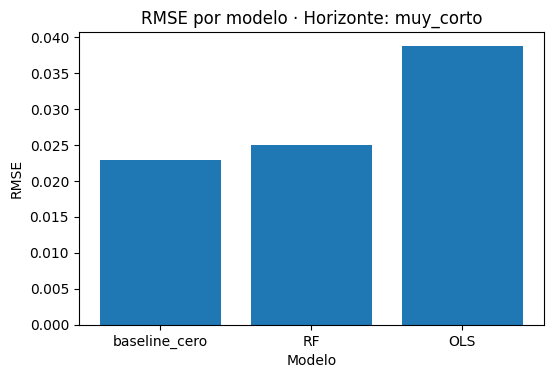

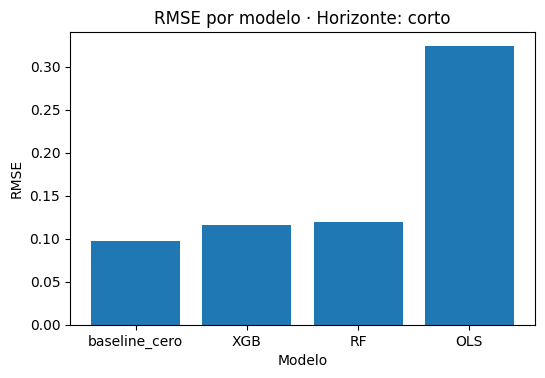

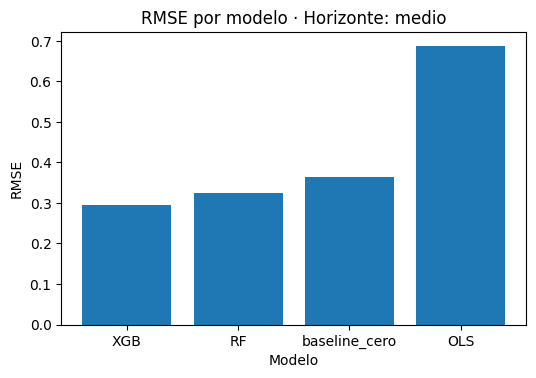

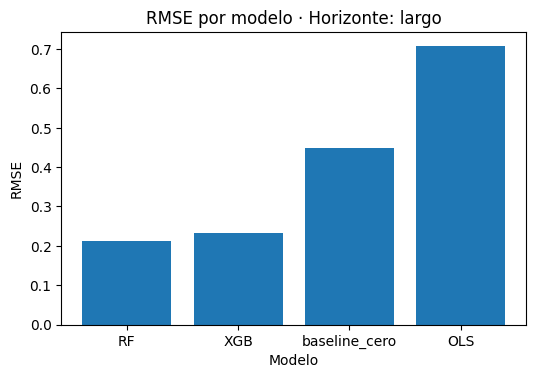

In [ ]:
# ===========================
# CELDA 1: COMPARATIVAS
# ===========================
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

# Intentar XGBoost
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

RANDOM_STATE = 42

# === Rutas y targets ===
FILES = {
    "muy_corto": ("AMZN_modelo_muy_corto_train.csv", "target_1d_logret_fwd"),
    "corto":     ("AMZN_modelo_corto_train.csv",     "target_21d_logret_fwd"),
    "medio":     ("AMZN_modelo_medio_train.csv",     "target_252d_logret_fwd"),
    "largo":     ("AMZN_modelo_largo_train.csv",     "target_504d_logret_fwd"),
}

# === Hiperparámetros "ganadores" de XGB por horizonte ===
XGB_BEST = {
    "corto": dict(n_estimators=800, max_depth=5, learning_rate=0.03,
                  subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
                  random_state=RANDOM_STATE, n_jobs=1, objective="reg:squarederror"),
    "medio": dict(n_estimators=800, max_depth=5, learning_rate=0.03,
                  subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
                  random_state=RANDOM_STATE, n_jobs=1, objective="reg:squarederror"),
    "largo": dict(n_estimators=800, max_depth=5, learning_rate=0.06,
                  subsample=0.8, colsample_bytree=0.8, min_child_weight=1,
                  random_state=RANDOM_STATE, n_jobs=1, objective="reg:squarederror"),
}

def load_Xy(path, target_col):
    df = pd.read_csv(path)
    num = df.select_dtypes(include="number").copy()
    if target_col not in num.columns:
        raise ValueError(f"No encuentro la columna objetivo: {target_col}")
    X = num.drop(columns=[target_col])
    y = num[target_col].values
    return df, X, y

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def evaluate_all_models(X, y, hz, n_splits=5):
    """
    Evalúa: baseline cero, OLS, RF y (si disponible) XGB (con tus hiperparámetros).
    Usa TimeSeriesSplit para mantener el orden temporal.
    Devuelve métricas promedio sobre los splits.
    """
    tss = TimeSeriesSplit(n_splits=n_splits)
    out = {"baseline_cero": [], "OLS": [], "RF": []}
    if HAS_XGB and hz in XGB_BEST:
        out["XGB"] = []

    for tr_idx, te_idx in tss.split(X):
        Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # Baseline 0
        yhat0 = np.zeros_like(yte)
        out["baseline_cero"].append((rmse(yte, yhat0), mean_absolute_error(yte, yhat0), r2_score(yte, yhat0)))

        # OLS
        ols = LinearRegression().fit(Xtr, ytr)
        yhat = ols.predict(Xte)
        out["OLS"].append((rmse(yte, yhat), mean_absolute_error(yte, yhat), r2_score(yte, yhat)))

        # RF (parámetros razonables y estables)
        rf = RandomForestRegressor(n_estimators=600, max_depth=8, random_state=RANDOM_STATE, n_jobs=-1).fit(Xtr, ytr)
        yhat = rf.predict(Xte)
        out["RF"].append((rmse(yte, yhat), mean_absolute_error(yte, yhat), r2_score(yte, yhat)))

        # XGB (si procede)
        if "XGB" in out:
            xg = xgb.XGBRegressor(**XGB_BEST[hz]).fit(Xtr, ytr)
            yhat = xg.predict(Xte)
            out["XGB"].append((rmse(yte, yhat), mean_absolute_error(yte, yhat), r2_score(yte, yhat)))

    # Promedios
    rows = []
    for model, triples in out.items():
        ms = np.array(triples)
        rows.append({
            "modelo": model,
            "rmse": ms[:,0].mean(),
            "mae":  ms[:,1].mean(),
            "r2":   ms[:,2].mean()
        })
    return pd.DataFrame(rows).sort_values("rmse")

# --- Ejecutar comparativa y dibujar ---
all_rows = []
for hz, (fname, target_col) in FILES.items():
    path = fname if os.path.exists(fname) else os.path.join("/mnt/data", fname)
    df, X, y = load_Xy(path, target_col)
    res = evaluate_all_models(X, y, hz)
    res.insert(0, "horizonte", hz)
    all_rows.append(res)

df_comp = pd.concat(all_rows, ignore_index=True)

# Tabla ordenada por horizonte/rmse
display(df_comp.sort_values(["horizonte","rmse"]))

# Gráficas por horizonte
for hz in FILES.keys():
    tmp = df_comp[df_comp["horizonte"] == hz].sort_values("rmse")
    plt.figure(figsize=(6,3.8))
    plt.bar(tmp["modelo"], tmp["rmse"])
    plt.title(f"RMSE por modelo · Horizonte: {hz}")
    plt.ylabel("RMSE")
    plt.xlabel("Modelo")
    plt.xticks(rotation=0)
    plt.show()
